In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, mean_squared_error
from sklearn.preprocessing import StandardScaler

import lightgbm as lgb

from catboost import CatBoostRegressor

from scipy.signal import correlate


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mb-tst/data.csv


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Читаем данные
data_df = pd.read_csv('/kaggle/input/mb-tst/data.csv')
data_df = data_df.drop(columns=['Unnamed: 0'])

In [4]:
# Переведем поле с датой в соответствующий тип
data_df['Date&Time'] = pd.to_datetime(data_df['Date&Time'])

# Устанавливаем 'datetime' как индекс
data_df = data_df.set_index('Date&Time')

# Нагенерим временных фичей для дальнейших группировок
data_df['day_date'] = pd.to_datetime(data_df.index.date)
data_df['dow'] = data_df['day_date'].dt.weekday + 1
data_df['week_date'] = data_df['day_date'] - pd.to_timedelta(data_df['day_date'].dt.weekday, unit='D')
data_df['mon_date'] = data_df['day_date'].apply(lambda x: x.replace(day=1))
data_df['hour'] = data_df.index.hour
data_df['month'] = data_df['day_date'].dt.month
data_df['doy'] = data_df['day_date'].dt.dayofyear
data_df['week_num'] = data_df['day_date'].dt.isocalendar().week
data_df['year'] = data_df['day_date'].dt.year

In [5]:
# Пока для простоты заполним NaN нулями
data_df = data_df.fillna(0)

## Как можно поставить задачу.
1. Нам не сказали на какой горизонт нужно делать прогноз и что является метрикой качества.  
2. Было сказано что нужно узнать о высокой нагрузке как можно раньше. Это очень абстрактно и нужно понимать проблематику. Возможно, для задачи будет достаточно знать об этом за 1 месяц, а может и за неделю. В зависимости от этого меняется горизонт нашего прогноза, его валидация и оценка точности.  
3. Если решать задачу как регрессию, то можно мерить RMSE. Тут мы будем настраиваться на выбросы (что нам и нужно). Не люблю RMSE на его слабую интерпретируемость.  
4. Можно решать задачу как классификацию. Тогда нам нужно понять что будет являться таргетом и разметить данные.  
5. Можно подумать над решением задачи с точки зрения вероятностей, заюзать quantile loss или типа того  
6. Из описания наша цель - **предсказать дни**, когда нагрузка на сервер будет <u>значительно выше стандартной</u>. Исходя из описания мы можем просто игнорировать разрез по часам

У нас нет доп информации про фичи. Можно предположить что они у нас всегда будут на неограниченный горизонт, т.к. иного не было сказано из описания. Сами же фичи выглядят как некоторые лаги таргета или что-то еще. По этому, с точки зрения здравого смысла, мы не все фичи можем знать заранее.  
Если будет время, то попробую отработать в двух вариантах.

Не понятна природа фичей, а следовательно не ясно можно ли их суммировать если мы ходим агрегировать данные например до дней.  
Кажется, что нагрузку на сервера суммировать можно. С другой стороны, если нам важно детектить именно пики, то, возможно, нужно брать max в качестве агрегиционной функции.

#### Первый подход к снаряду.  
Считаю что: 
* можно использовать все фичи без зазрения совести
* горизонт: месяц
* CV: 12 периодов
* метрика качества: RMSE
* агрегация: дни
* модель: RF

In [6]:
features = [
    'feature_1', 'feature_2', 'feature_3', 'feature_4',
    'feature_5', 'feature_6', 'feature_7', 'feature_8', 
    'feature_10', 'feature_11', 'feature_12',
]
target = 'target'

In [7]:
day_data_df = data_df.groupby(
    ['day_date', 'dow', 'week_date', 'mon_date', 'doy', 'week_num', 'year', 'month']
)[features + [target]].sum().reset_index()

In [8]:
# Сортируем по дням
day_data_df = day_data_df.sort_values(by='day_date')

In [9]:
# Фичи к исключению
exc_f = ['day_date', 'week_date', 'mon_date']

In [10]:
def plot_res(X_val, y_val, y_val_pred, val_min_date, val_max_date):
    """
    Построение графика для текущего периода кросс-валидации
    """
    plt.figure(figsize=(10, 6))
    
    # Фактические значения
    plt.plot(X_val['day_date'], y_val, label='Actual', color='blue')
    
    # Предсказанные значения
    plt.plot(X_val['day_date'], y_val_pred, label='Predicted', color='orange')
    
    plt.title(f'Cross Validation Period from {val_min_date} to {val_max_date}: Predicted vs Actual')
    plt.xlabel('Date')
    plt.ylabel('Target')
    plt.legend()
    
    # Отображение графика
    plt.grid(True)
    plt.show()

## Юзаем RF

Train dates from 2021-01-01 00:00:00 to 2023-06-25 00:00:00.
Val dates from 2023-06-26 00:00:00 to 2023-07-25 00:00:00.
Train RMSE: 55.0771, Validation RMSE (last month): 11.9613 



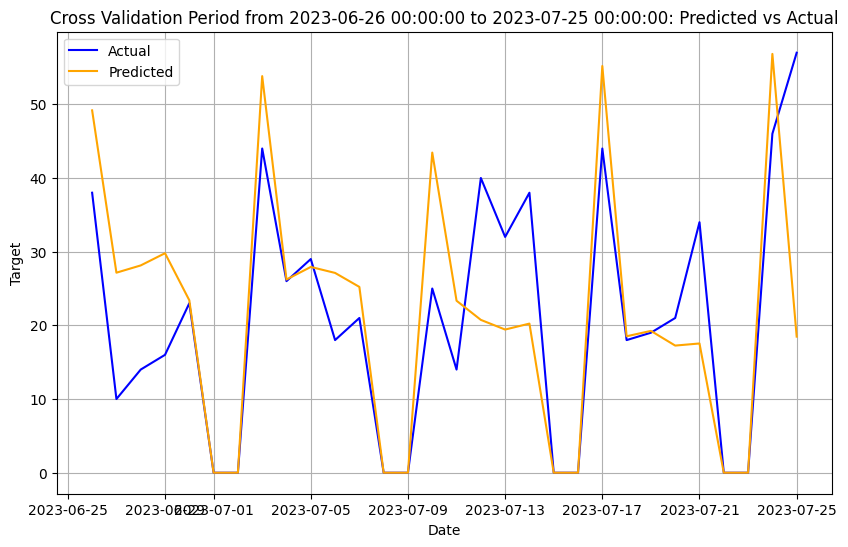

Train dates from 2021-01-01 00:00:00 to 2023-07-25 00:00:00.
Val dates from 2023-07-26 00:00:00 to 2023-08-24 00:00:00.
Train RMSE: 54.4041, Validation RMSE (last month): 585.4120 



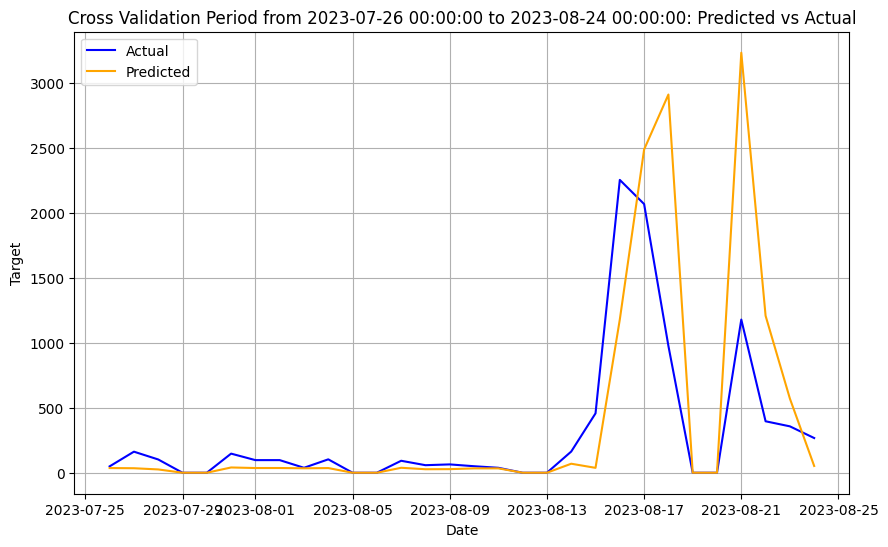

Train dates from 2021-01-01 00:00:00 to 2023-08-24 00:00:00.
Val dates from 2023-08-25 00:00:00 to 2023-09-23 00:00:00.
Train RMSE: 57.5577, Validation RMSE (last month): 292.9367 



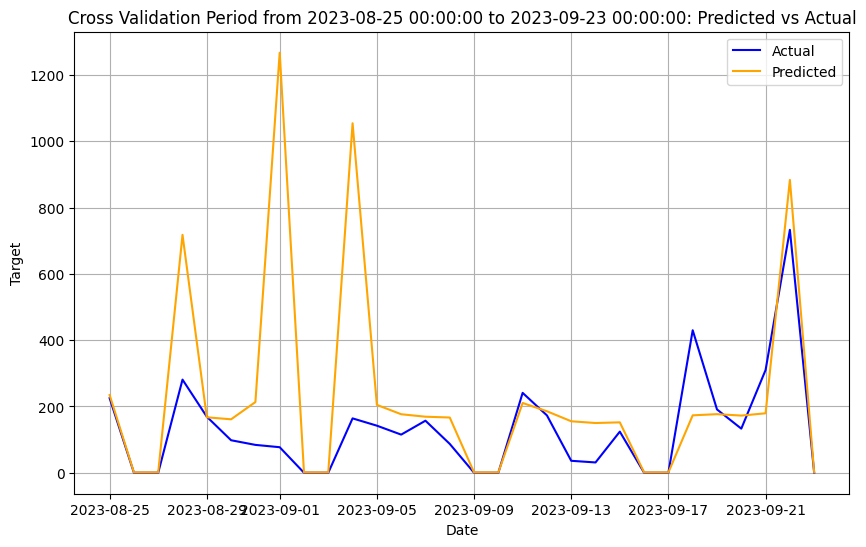

Train dates from 2021-01-01 00:00:00 to 2023-09-23 00:00:00.
Val dates from 2023-09-24 00:00:00 to 2023-10-23 00:00:00.
Train RMSE: 55.0454, Validation RMSE (last month): 301.3009 



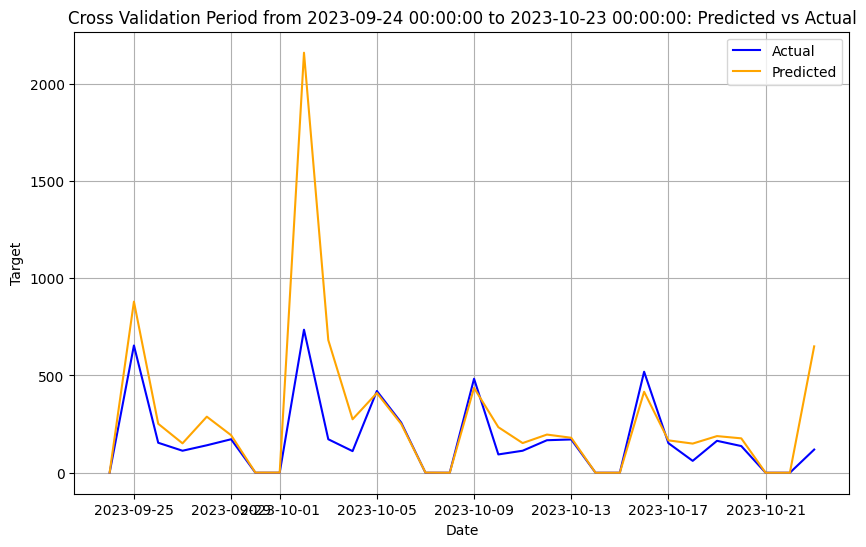

Train dates from 2021-01-01 00:00:00 to 2023-10-23 00:00:00.
Val dates from 2023-10-24 00:00:00 to 2023-11-22 00:00:00.
Train RMSE: 53.9067, Validation RMSE (last month): 419.1484 



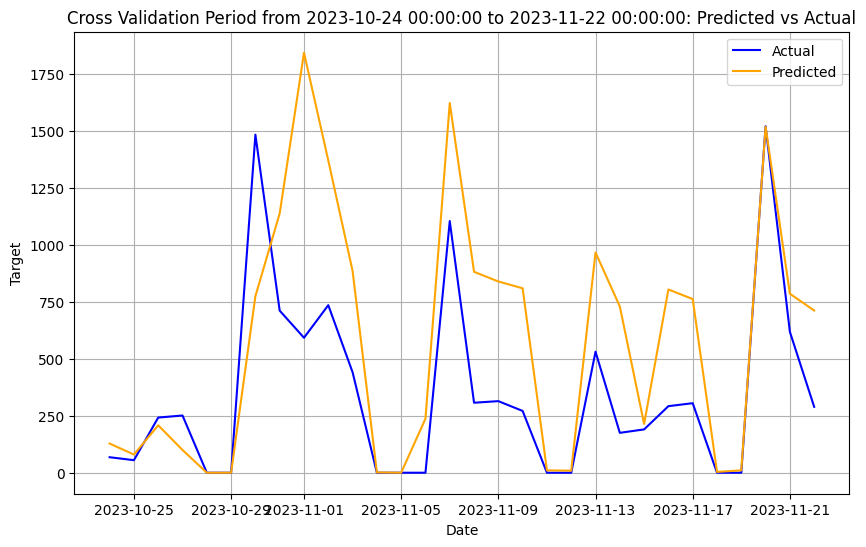

Train dates from 2021-01-01 00:00:00 to 2023-11-22 00:00:00.
Val dates from 2023-11-23 00:00:00 to 2023-12-22 00:00:00.
Train RMSE: 53.5923, Validation RMSE (last month): 145.4713 



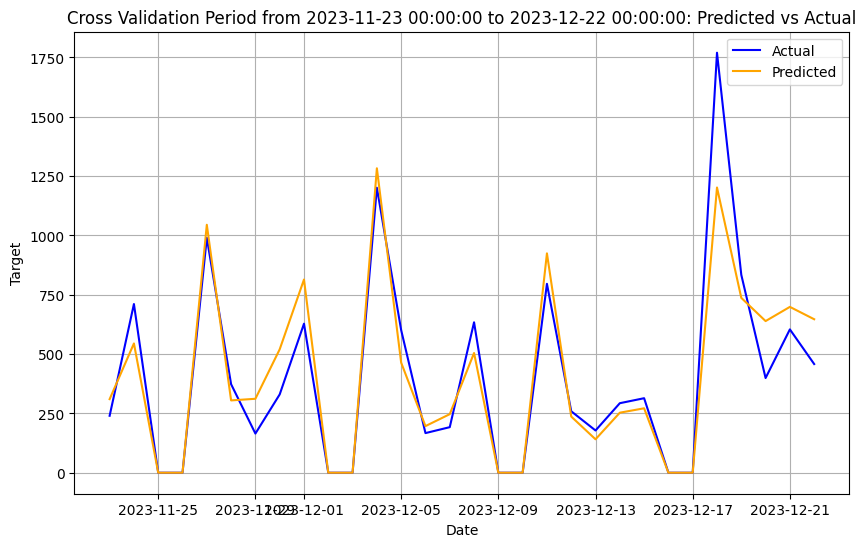

Train dates from 2021-01-01 00:00:00 to 2023-12-22 00:00:00.
Val dates from 2023-12-23 00:00:00 to 2024-01-21 00:00:00.
Train RMSE: 52.9208, Validation RMSE (last month): 875.0825 



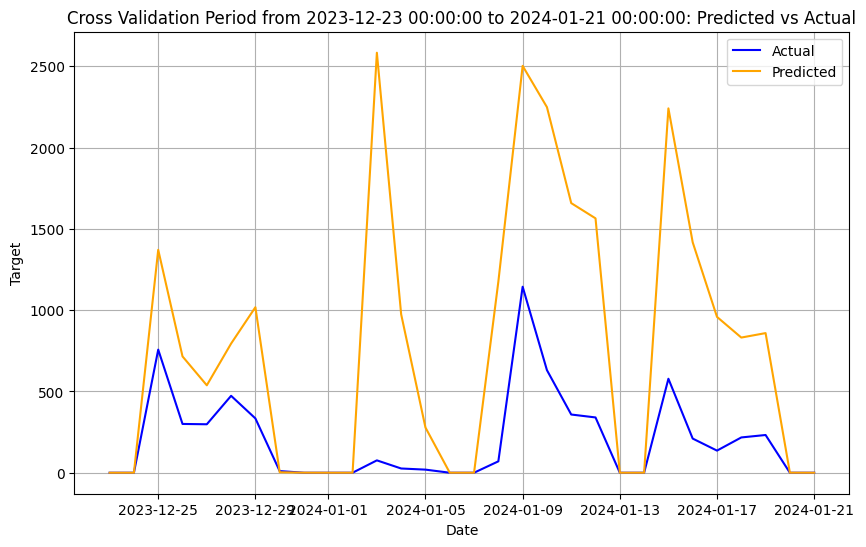

Train dates from 2021-01-01 00:00:00 to 2024-01-21 00:00:00.
Val dates from 2024-01-22 00:00:00 to 2024-02-20 00:00:00.
Train RMSE: 55.8290, Validation RMSE (last month): 124.1198 



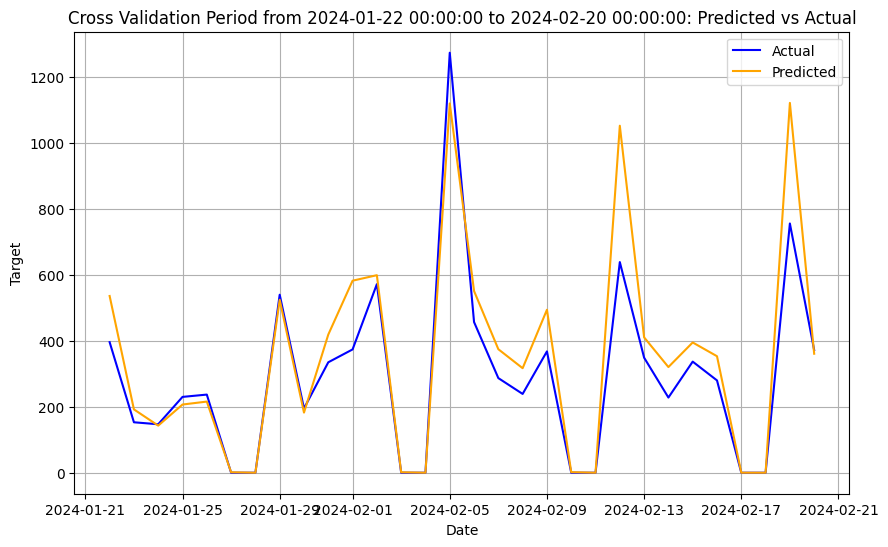

Train dates from 2021-01-01 00:00:00 to 2024-02-20 00:00:00.
Val dates from 2024-02-21 00:00:00 to 2024-03-21 00:00:00.
Train RMSE: 54.5342, Validation RMSE (last month): 142.0545 



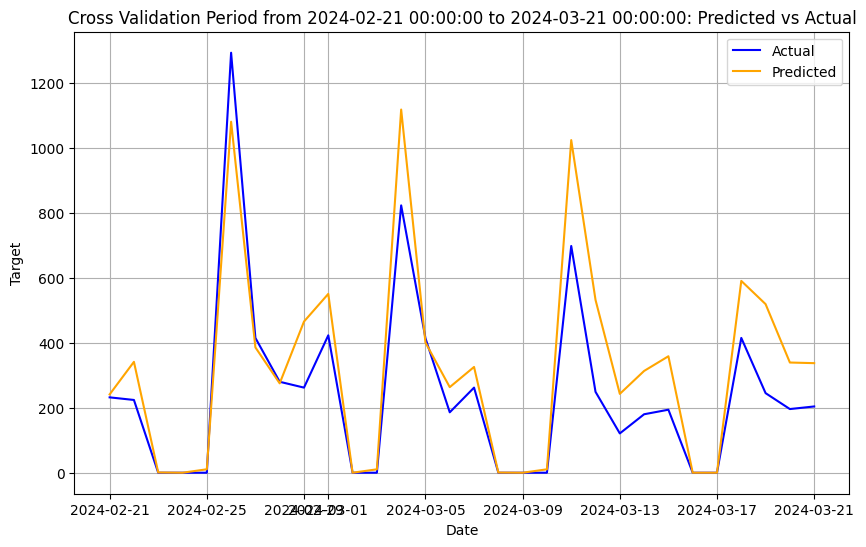

Train dates from 2021-01-01 00:00:00 to 2024-03-21 00:00:00.
Val dates from 2024-03-22 00:00:00 to 2024-04-20 00:00:00.
Train RMSE: 52.4947, Validation RMSE (last month): 213.3368 



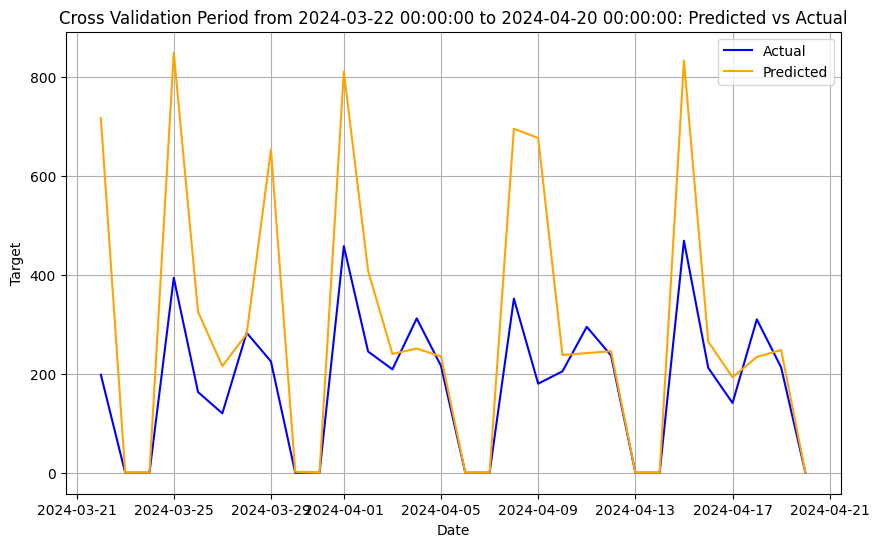

Train dates from 2021-01-01 00:00:00 to 2024-04-20 00:00:00.
Val dates from 2024-04-21 00:00:00 to 2024-05-20 00:00:00.
Train RMSE: 50.6045, Validation RMSE (last month): 227.0877 



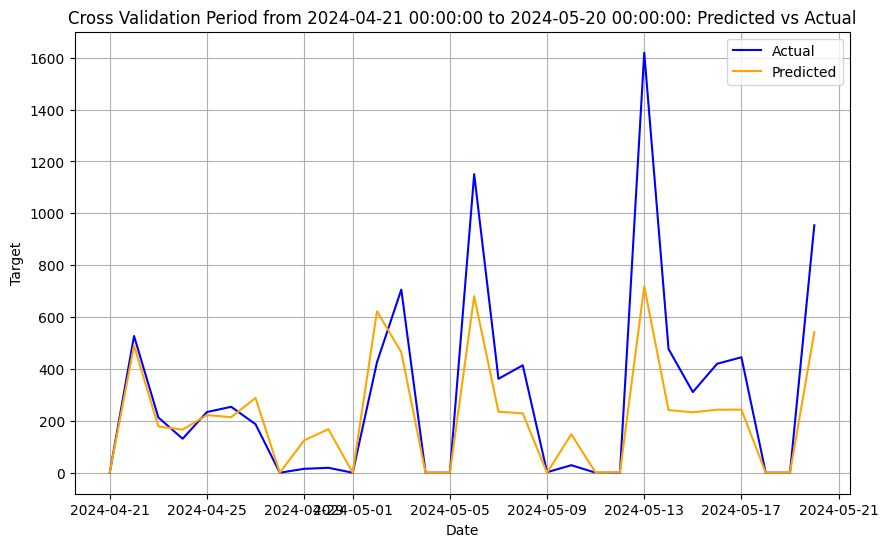

Train dates from 2021-01-01 00:00:00 to 2024-05-20 00:00:00.
Val dates from 2024-05-21 00:00:00 to 2024-06-19 00:00:00.
Train RMSE: 51.0036, Validation RMSE (last month): 224.9701 



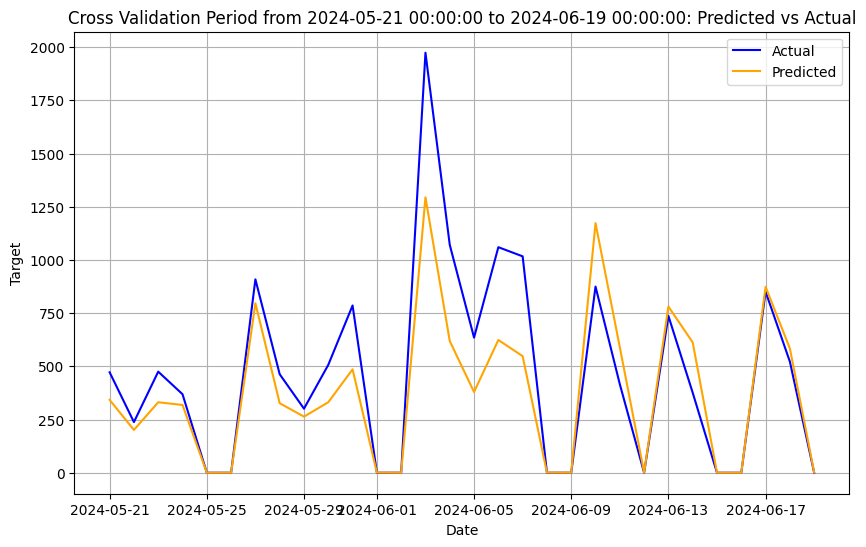

Среднее значение Train RMSE: 53.9142
Среднее значение Validation RMSE: 296.9068


In [11]:

X = day_data_df.drop(columns=[target])
y = day_data_df[target]

# Число дней в месяце
days_in_month = 30

# Число периодов кросс-валидации (12 месяцев)
n_splits = 12  

# Определяем TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=n_splits, test_size=days_in_month)

# Модель RandomForest
model = RandomForestRegressor(random_state=42, n_estimators=1000)

# Списки для сохранения метрик
train_errors = []
val_errors = []


# Кросс-валидация
for train_index, val_index in tscv.split(X):
    # Используем только последний месяц валидационного периода
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    
    # Запоминаем даты
    train_min_date = X_train['day_date'].min()
    train_max_date = X_train['day_date'].max()
    val_min_date = X_val['day_date'].min()
    val_max_date = X_val['day_date'].max()
    
    # Обучаем модель на тренировочных данных
    model.fit(X_train.drop(columns=exc_f), y_train)
    
    # Предсказания на тренировочном и валидационном наборах
    y_train_pred = model.predict(X_train.drop(columns=exc_f))
    y_val_pred = model.predict(X_val.drop(columns=exc_f))
    
    # Оцениваем ошибки
    train_error = mean_squared_error(y_train, y_train_pred, squared=False)
    val_error = mean_squared_error(y_val, y_val_pred, squared=False)
    
    train_errors.append(train_error)
    val_errors.append(val_error)
    
    print(f'Train dates from {train_min_date} to {train_max_date}.\nVal dates from {val_min_date} to {val_max_date}.')
    print(f'Train RMSE: {train_error:.4f}, Validation RMSE (last month): {val_error:.4f} \n')
    
    # Нарисуем график
    plot_res(X_val, y_val, y_val_pred, val_min_date, val_max_date)


# Выводим средние ошибки по всем периодам кросс-валидации
print(f'Среднее значение Train RMSE: {np.mean(train_errors):.4f}')
print(f'Среднее значение Validation RMSE: {np.mean(val_errors):.4f}')

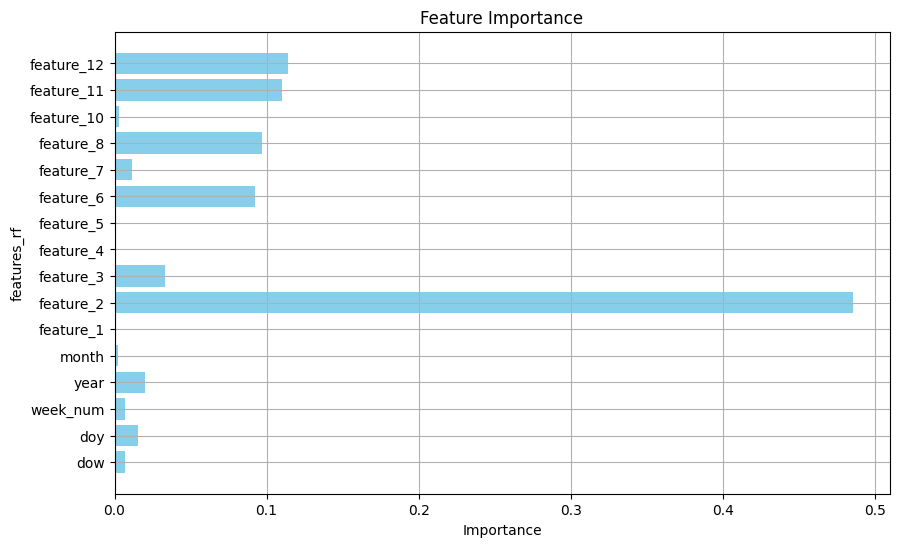

In [12]:
# Вывод важности признаков для последней модели
feature_importance = model.feature_importances_
features_rf = X_train.drop(columns=exc_f).columns

# Построение графика важности признаков
plt.figure(figsize=(10, 6))
plt.barh(features_rf, feature_importance, color='skyblue')
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('features_rf')
plt.grid(True)
plt.show()

* Самая сильная фича №2.  
* Модель плохо предсказывает в января, наверное из-за праздников
* Можно погенерить фич: лаги таргета, лаги фичей, max, min, std, rollings
* Можно поупарываться и анализировать отдельные ошибки чтобы понять как улучшать. На это времени нет.
* Можно потюнить количество деревьев, пойти в бустинг
* Можно повысить веса для больших значений, чтобы модель подстраивалась под них

## Пробуем LightGBM.
Метрика чуть лучше, но прогнозы так себе  
Можно много чего попробовать, но пока пропустим, времени мало

Train dates from 2021-01-01 00:00:00 to 2023-06-25 00:00:00.
Val dates from 2023-06-26 00:00:00 to 2023-07-25 00:00:00.
Train RMSE: 251.7381, Validation RMSE (last month): 54.7391 



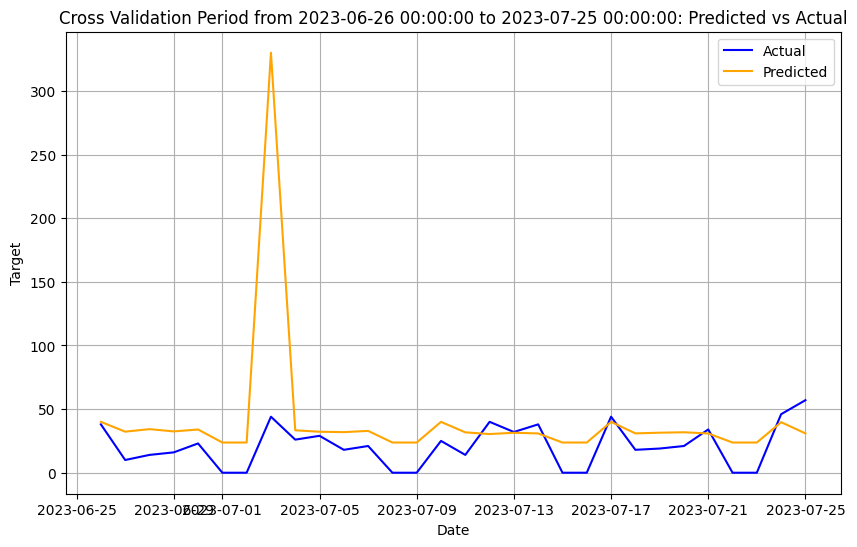

Train dates from 2021-01-01 00:00:00 to 2023-07-25 00:00:00.
Val dates from 2023-07-26 00:00:00 to 2023-08-24 00:00:00.
Train RMSE: 251.5161, Validation RMSE (last month): 546.4402 



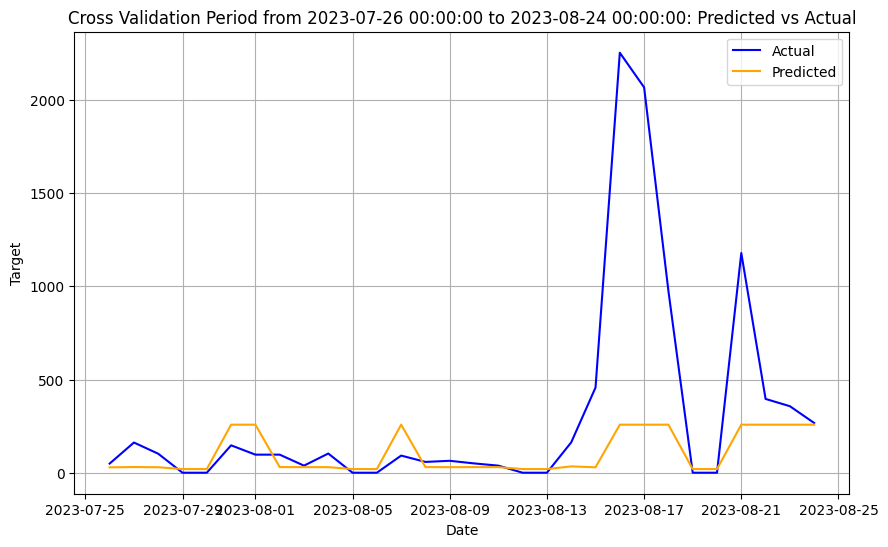

Train dates from 2021-01-01 00:00:00 to 2023-08-24 00:00:00.
Val dates from 2023-08-25 00:00:00 to 2023-09-23 00:00:00.
Train RMSE: 262.7514, Validation RMSE (last month): 122.2279 



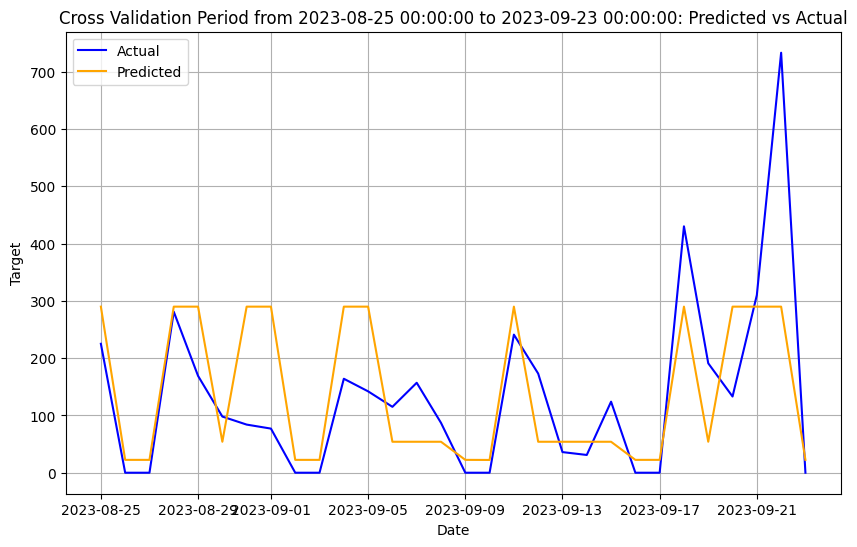

Train dates from 2021-01-01 00:00:00 to 2023-09-23 00:00:00.
Val dates from 2023-09-24 00:00:00 to 2023-10-23 00:00:00.
Train RMSE: 246.9162, Validation RMSE (last month): 113.5621 



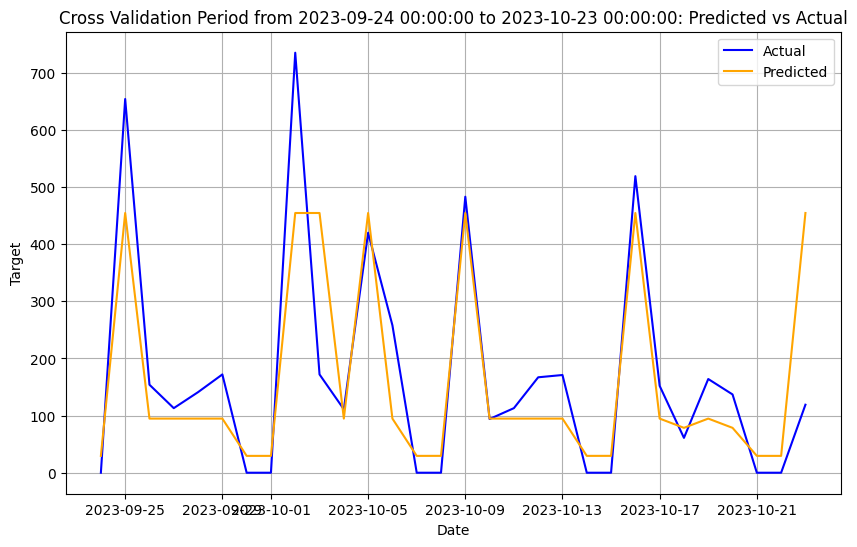

Train dates from 2021-01-01 00:00:00 to 2023-10-23 00:00:00.
Val dates from 2023-10-24 00:00:00 to 2023-11-22 00:00:00.
Train RMSE: 241.8910, Validation RMSE (last month): 309.1498 



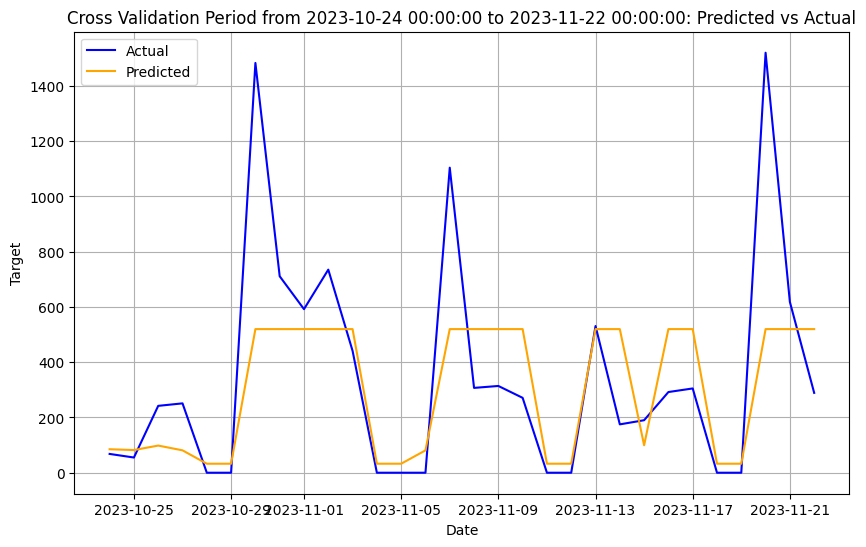

Train dates from 2021-01-01 00:00:00 to 2023-11-22 00:00:00.
Val dates from 2023-11-23 00:00:00 to 2023-12-22 00:00:00.
Train RMSE: 250.6714, Validation RMSE (last month): 338.7895 



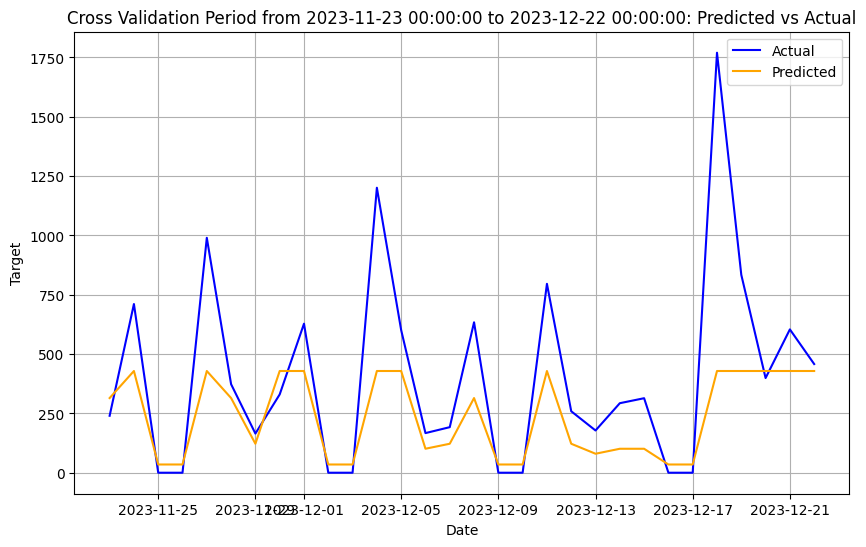

Train dates from 2021-01-01 00:00:00 to 2023-12-22 00:00:00.
Val dates from 2023-12-23 00:00:00 to 2024-01-21 00:00:00.
Train RMSE: 247.0268, Validation RMSE (last month): 174.4708 



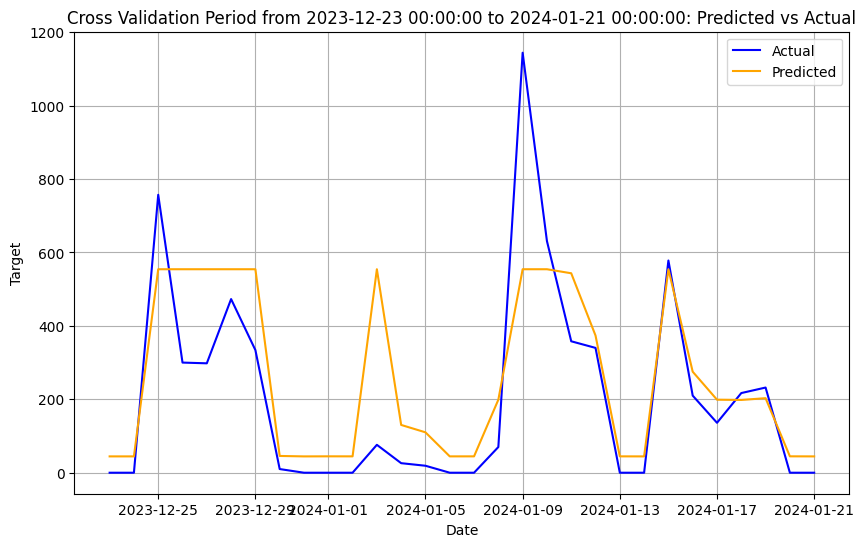

Train dates from 2021-01-01 00:00:00 to 2024-01-21 00:00:00.
Val dates from 2024-01-22 00:00:00 to 2024-02-20 00:00:00.
Train RMSE: 259.0617, Validation RMSE (last month): 198.5843 



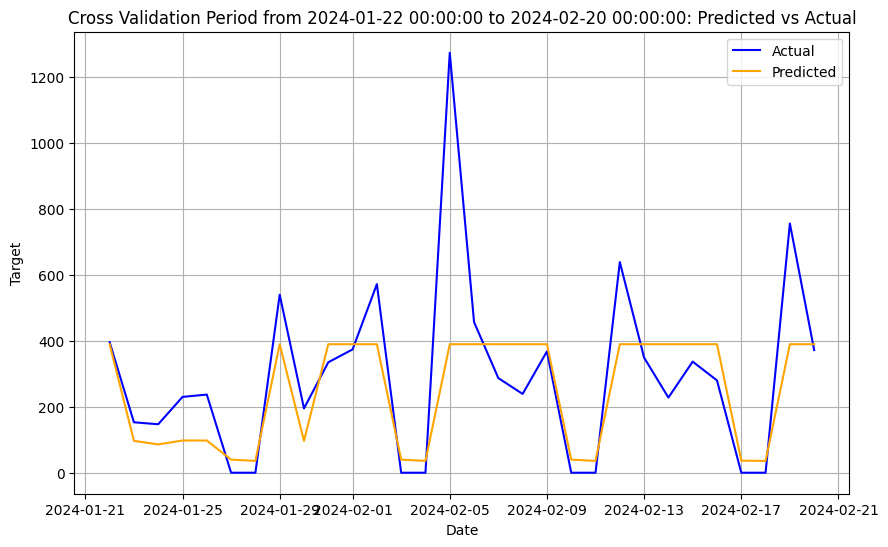

Train dates from 2021-01-01 00:00:00 to 2024-02-20 00:00:00.
Val dates from 2024-02-21 00:00:00 to 2024-03-21 00:00:00.
Train RMSE: 252.6255, Validation RMSE (last month): 210.6166 



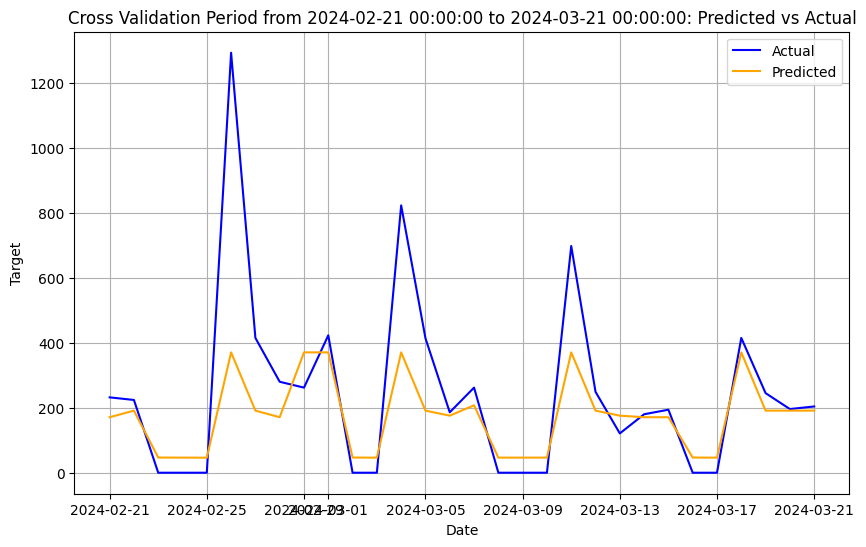

Train dates from 2021-01-01 00:00:00 to 2024-03-21 00:00:00.
Val dates from 2024-03-22 00:00:00 to 2024-04-20 00:00:00.
Train RMSE: 248.8155, Validation RMSE (last month): 74.3429 



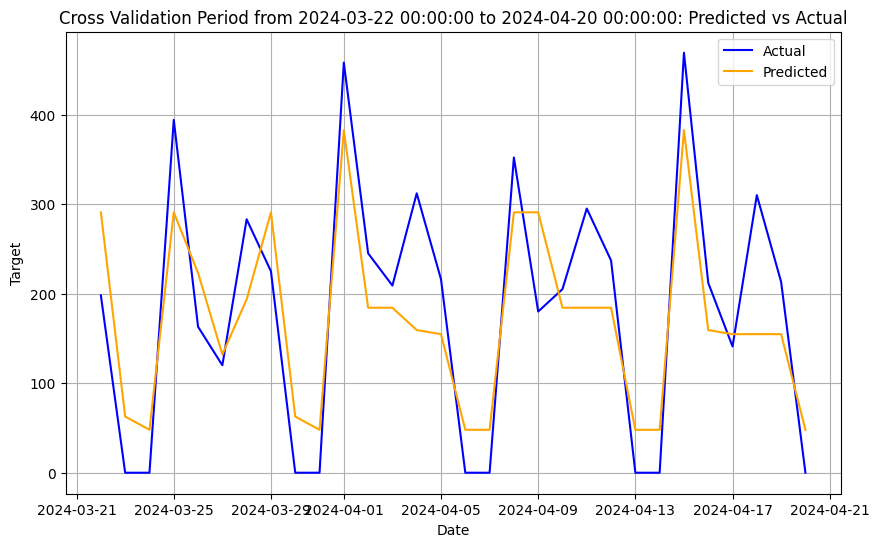

Train dates from 2021-01-01 00:00:00 to 2024-04-20 00:00:00.
Val dates from 2024-04-21 00:00:00 to 2024-05-20 00:00:00.
Train RMSE: 252.7853, Validation RMSE (last month): 354.5640 



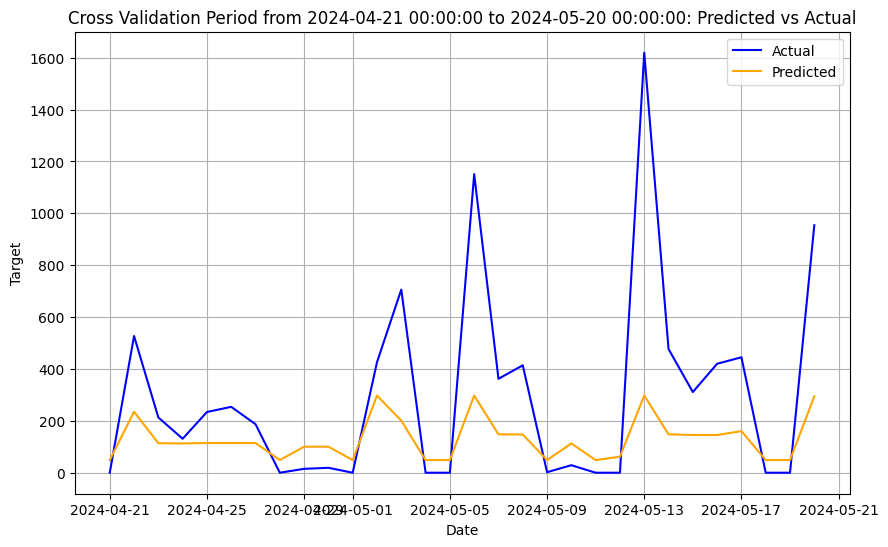

Train dates from 2021-01-01 00:00:00 to 2024-05-20 00:00:00.
Val dates from 2024-05-21 00:00:00 to 2024-06-19 00:00:00.
Train RMSE: 249.0401, Validation RMSE (last month): 453.1280 



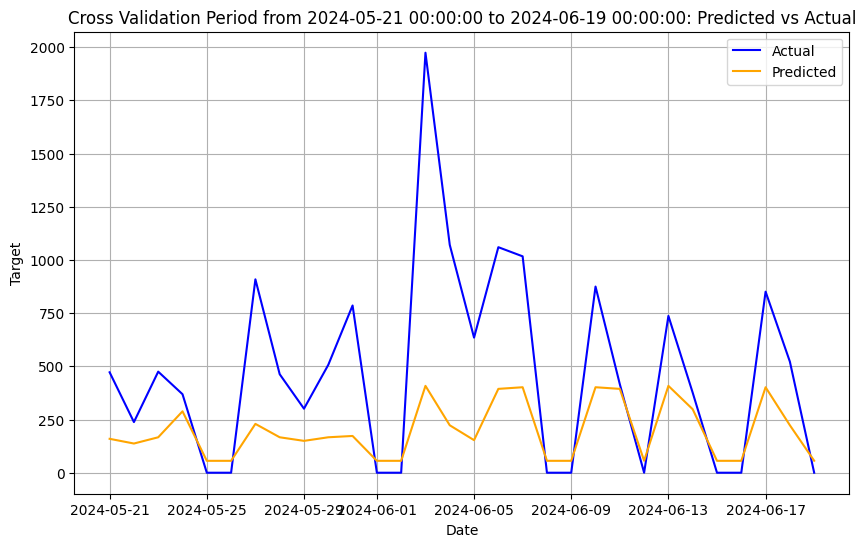

Среднее значение Train RMSE: 251.2366
Среднее значение Validation RMSE: 245.8846


In [13]:
# Датафрейм с данными
# df['target'] - это наш таргет, а остальная часть df - это фичи
X = day_data_df.drop(columns=[target])
y = day_data_df[target]

# Число дней в месяце
days_in_month = 30

# Число периодов кросс-валидации (12 месяцев)
n_splits = 12  

# Определяем TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=n_splits, test_size=days_in_month)

# Параметры для модели LightGBM
params = {
    'objective': 'regression',
    'num_iterations': 50,
    'metric': 'rmse',
#     'feature_fraction': 0.9,
#     'bagging_fraction': 0.7,
#     'bagging_freq': 10,
    'boosting_type': 'gbdt',
    'learning_rate': 0.01,
#     'num_leaves': 31,
#     'max_depth': -1,
#     'min_data_in_leaf': 20,
#     'early_stopping_rounds': 50,
    'verbose_eval': 100,
    'verbose': -1,
}


# Списки для сохранения метрик
train_errors = []
val_errors = []

# Процент данных для валидационного набора из тренировочного сета
validation_fraction = 0.2  # 20% от тренировочного набора будет использоваться для валидации


# Кросс-валидация
for train_index, val_index in tscv.split(X):
    # Используем только последний месяц валидационного периода
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    
    # Запоминаем даты
    train_min_date = X_train['day_date'].min()
    train_max_date = X_train['day_date'].max()
    val_min_date = X_val['day_date'].min()
    val_max_date = X_val['day_date'].max()
    
    # Случайное разделение тренировочного набора на обучение и валидацию
    X_train_part, X_val_part, y_train_part, y_val_part = train_test_split(
        X_train, y_train, test_size=validation_fraction, shuffle=True, random_state=42
    )
    
    # Создаем датасеты для LightGBM
    train_data = lgb.Dataset(X_train_part.drop(columns=exc_f), label=y_train_part)
    val_data = lgb.Dataset(X_val_part.drop(columns=exc_f), label=y_val_part, reference=train_data)
    
    callbacks = [lgb.log_evaluation(period=100)]
    
    # Обучаем модель на тренировочных данных
    model = lgb.train(
        params,
        train_data,
        valid_sets=[train_data, val_data],
        callbacks=callbacks,
    )
    
    # Предсказания на тренировочном и валидационном наборах
    y_train_pred = model.predict(X_train.drop(columns=exc_f))
    y_val_pred = model.predict(X_val.drop(columns=exc_f))
    
    # Оцениваем ошибки
    train_error = mean_squared_error(y_train, y_train_pred, squared=False)
    val_error = mean_squared_error(y_val, y_val_pred, squared=False)
    
    train_errors.append(train_error)
    val_errors.append(val_error)
    
    print(f'Train dates from {train_min_date} to {train_max_date}.\nVal dates from {val_min_date} to {val_max_date}.')
    print(f'Train RMSE: {train_error:.4f}, Validation RMSE (last month): {val_error:.4f} \n')
    
    # Нарисуем график
    plot_res(X_val, y_val, y_val_pred, val_min_date, val_max_date)


# Выводим средние ошибки по всем периодам кросс-валидации
print(f'Среднее значение Train RMSE: {np.mean(train_errors):.4f}')
print(f'Среднее значение Validation RMSE: {np.mean(val_errors):.4f}')

## Пробуем L1 регрессию
Результат хуже. Тут тоже можно еще много чего сделать, например не тренироваться на старых данных, где много пропусков у фичей итп

Train dates from 2021-01-01 00:00:00 to 2023-06-25 00:00:00.
Val dates from 2023-06-26 00:00:00 to 2023-07-25 00:00:00.
Train RMSE: 129.0098, Validation RMSE (last month): 163.1682 



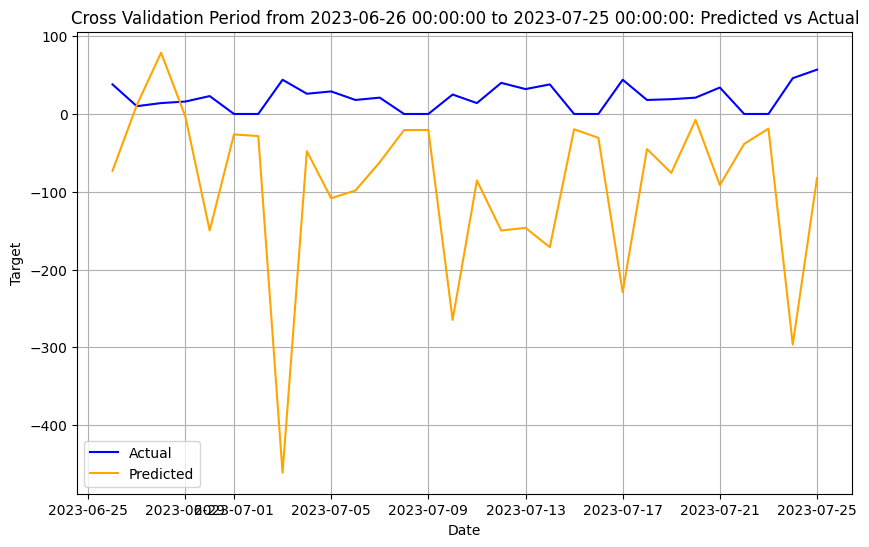

Train dates from 2021-01-01 00:00:00 to 2023-07-25 00:00:00.
Val dates from 2023-07-26 00:00:00 to 2023-08-24 00:00:00.
Train RMSE: 133.6812, Validation RMSE (last month): 432.7612 



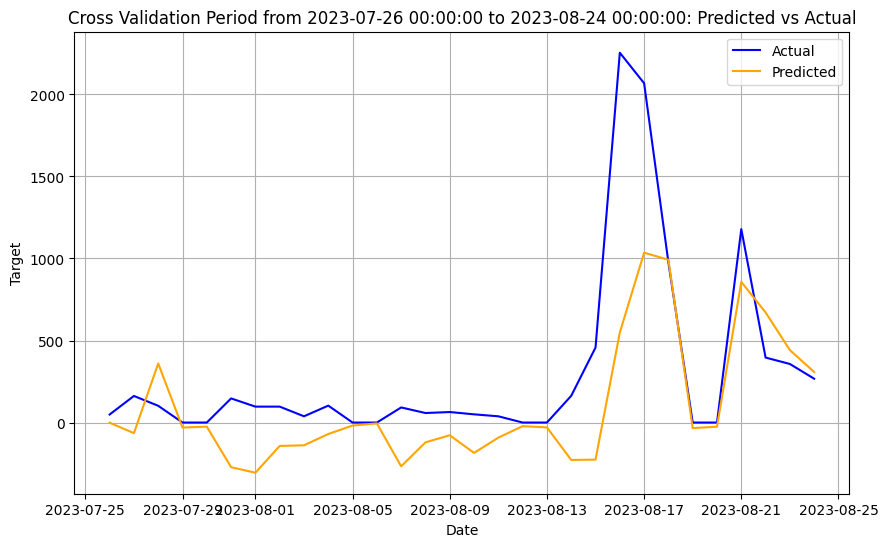

Train dates from 2021-01-01 00:00:00 to 2023-08-24 00:00:00.
Val dates from 2023-08-25 00:00:00 to 2023-09-23 00:00:00.
Train RMSE: 148.5405, Validation RMSE (last month): 180.2981 



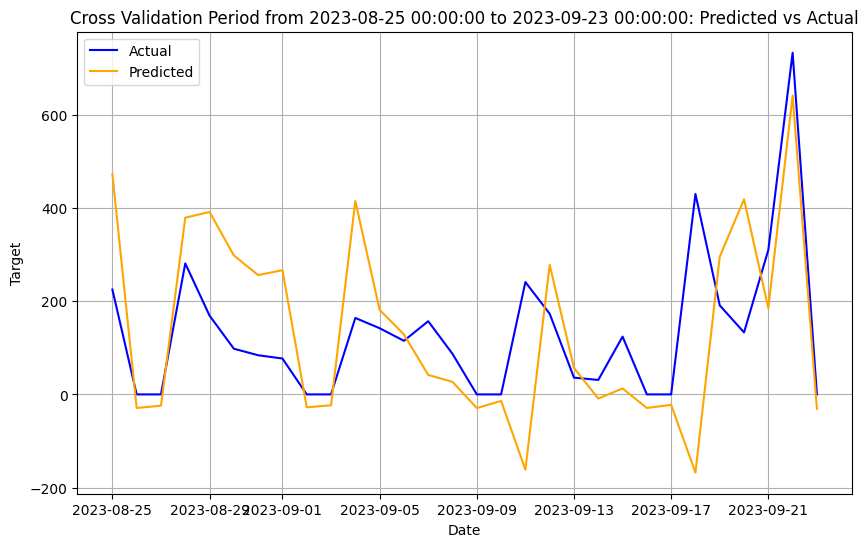

Train dates from 2021-01-01 00:00:00 to 2023-09-23 00:00:00.
Val dates from 2023-09-24 00:00:00 to 2023-10-23 00:00:00.
Train RMSE: 145.7411, Validation RMSE (last month): 246.4564 



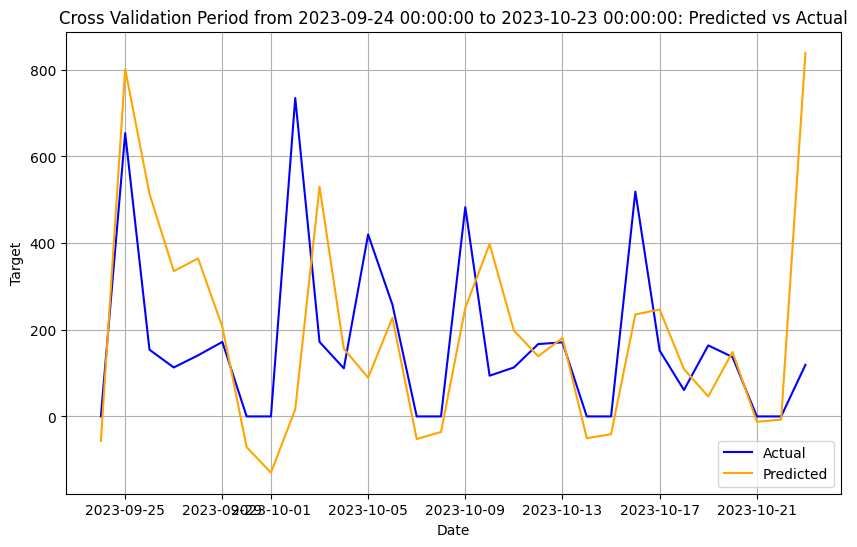

Train dates from 2021-01-01 00:00:00 to 2023-10-23 00:00:00.
Val dates from 2023-10-24 00:00:00 to 2023-11-22 00:00:00.
Train RMSE: 148.6031, Validation RMSE (last month): 359.8787 



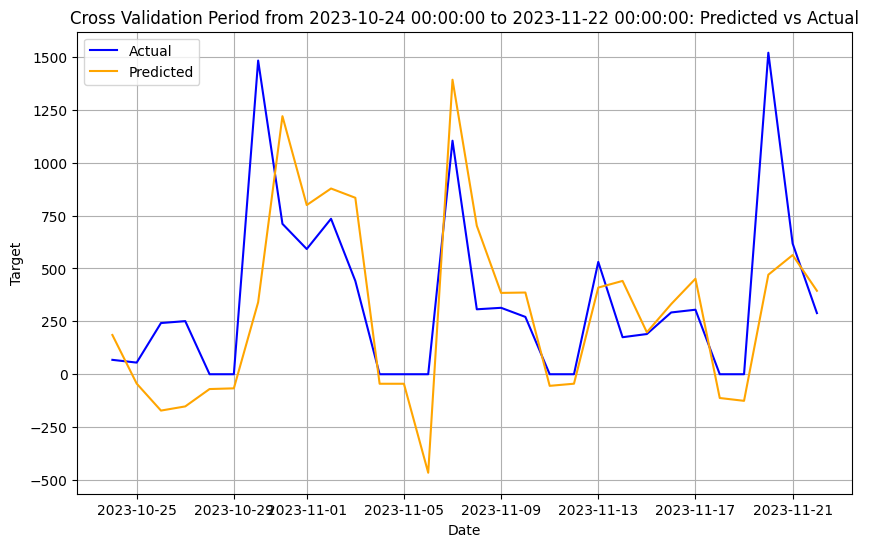

Train dates from 2021-01-01 00:00:00 to 2023-11-22 00:00:00.
Val dates from 2023-11-23 00:00:00 to 2023-12-22 00:00:00.
Train RMSE: 160.8271, Validation RMSE (last month): 355.7648 



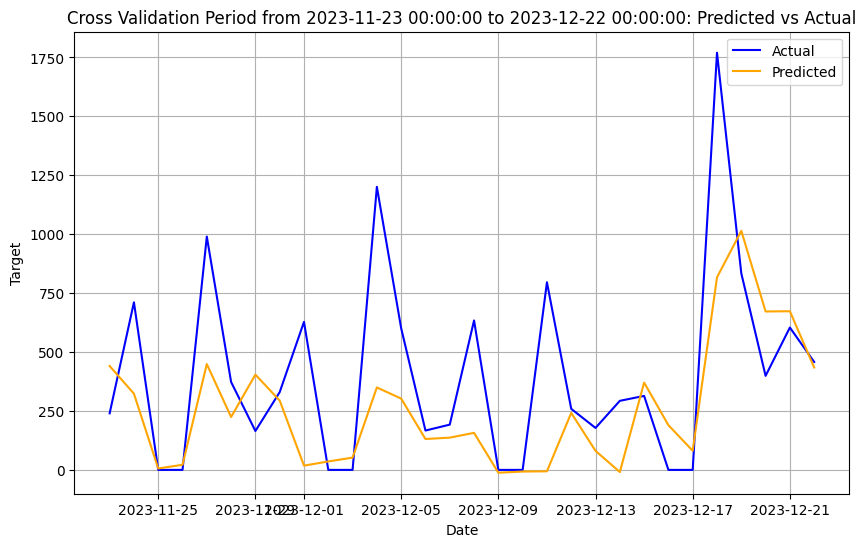

Train dates from 2021-01-01 00:00:00 to 2023-12-22 00:00:00.
Val dates from 2023-12-23 00:00:00 to 2024-01-21 00:00:00.
Train RMSE: 163.4114, Validation RMSE (last month): 320.0553 



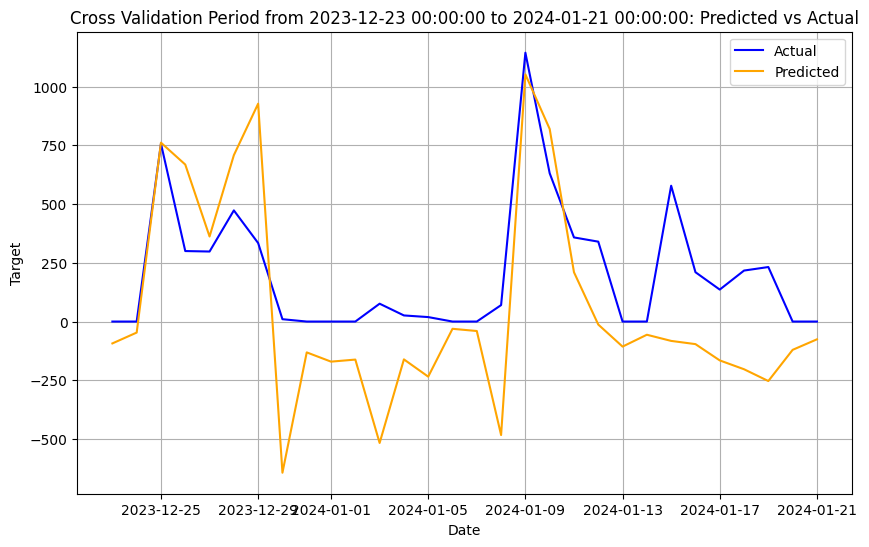

Train dates from 2021-01-01 00:00:00 to 2024-01-21 00:00:00.
Val dates from 2024-01-22 00:00:00 to 2024-02-20 00:00:00.
Train RMSE: 179.1470, Validation RMSE (last month): 219.7969 



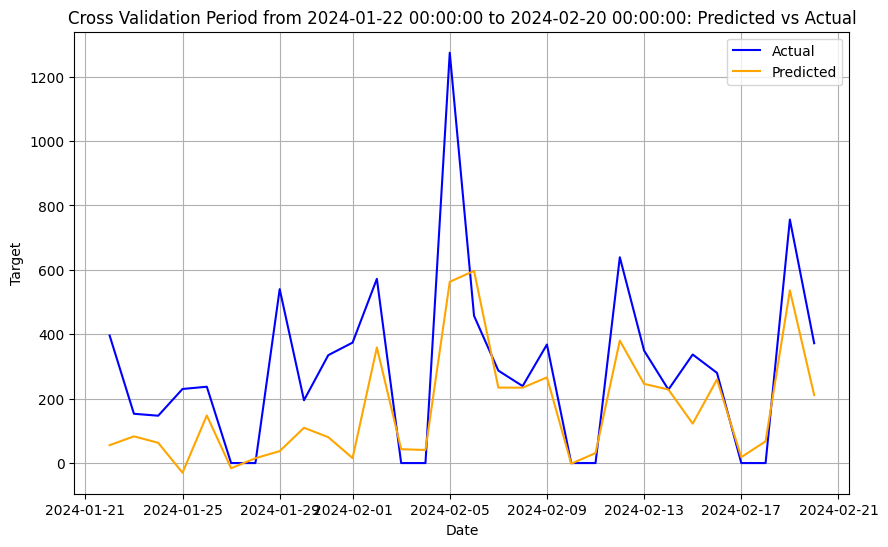

Train dates from 2021-01-01 00:00:00 to 2024-02-20 00:00:00.
Val dates from 2024-02-21 00:00:00 to 2024-03-21 00:00:00.
Train RMSE: 172.0804, Validation RMSE (last month): 372.8237 



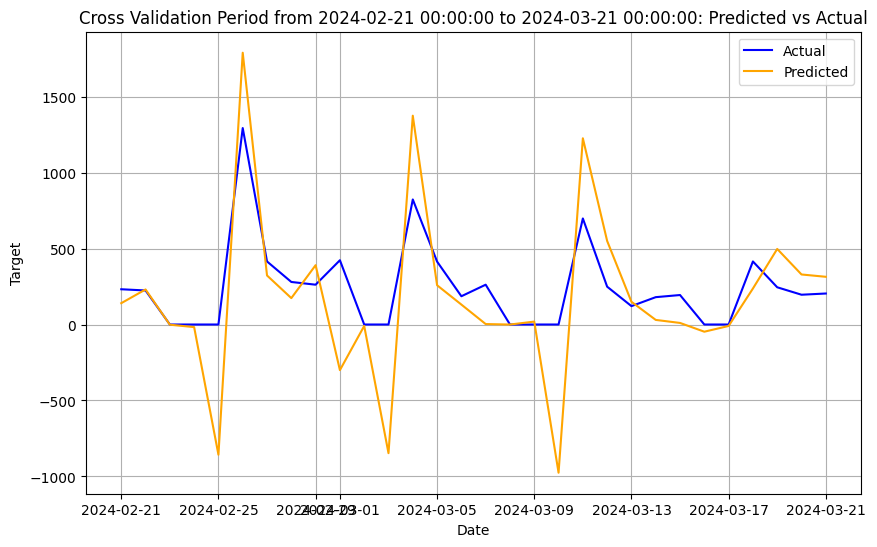

Train dates from 2021-01-01 00:00:00 to 2024-03-21 00:00:00.
Val dates from 2024-03-22 00:00:00 to 2024-04-20 00:00:00.
Train RMSE: 181.4313, Validation RMSE (last month): 376.7248 



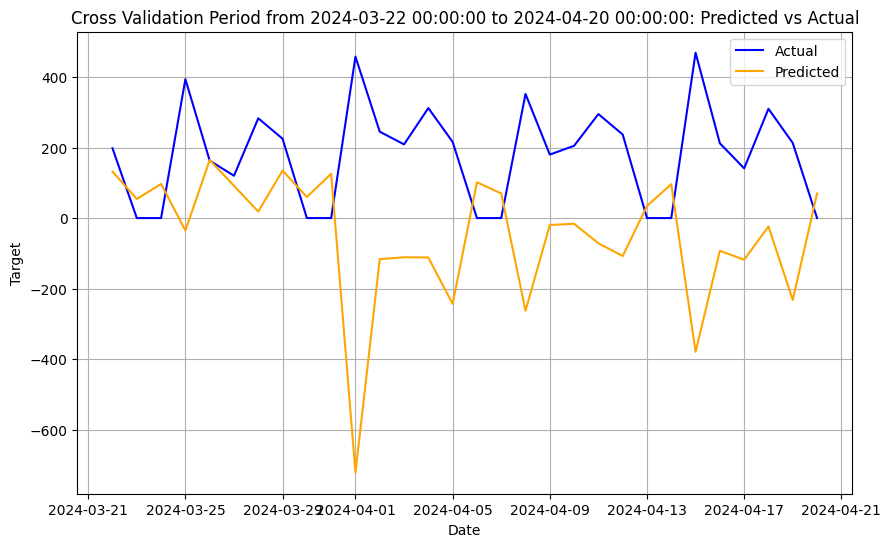

Train dates from 2021-01-01 00:00:00 to 2024-04-20 00:00:00.
Val dates from 2024-04-21 00:00:00 to 2024-05-20 00:00:00.
Train RMSE: 193.5335, Validation RMSE (last month): 448.4668 



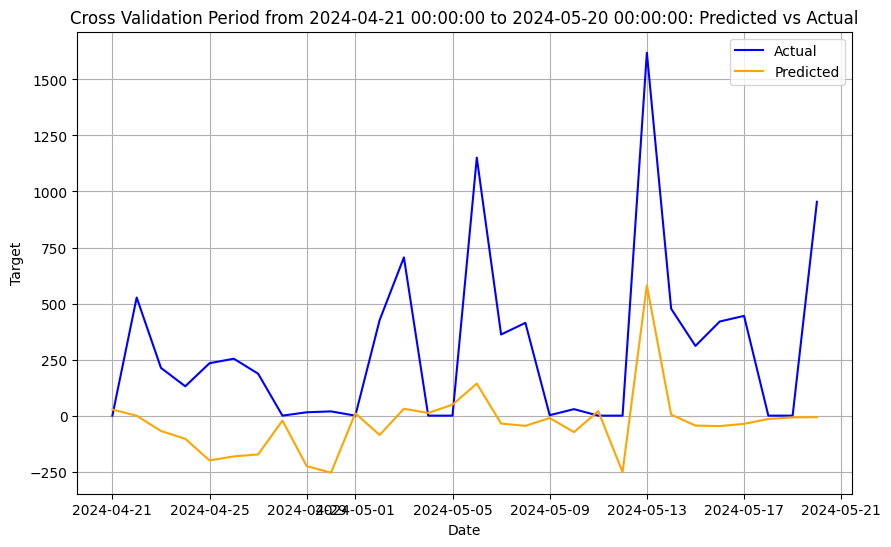

Train dates from 2021-01-01 00:00:00 to 2024-05-20 00:00:00.
Val dates from 2024-05-21 00:00:00 to 2024-06-19 00:00:00.
Train RMSE: 191.5764, Validation RMSE (last month): 500.3651 



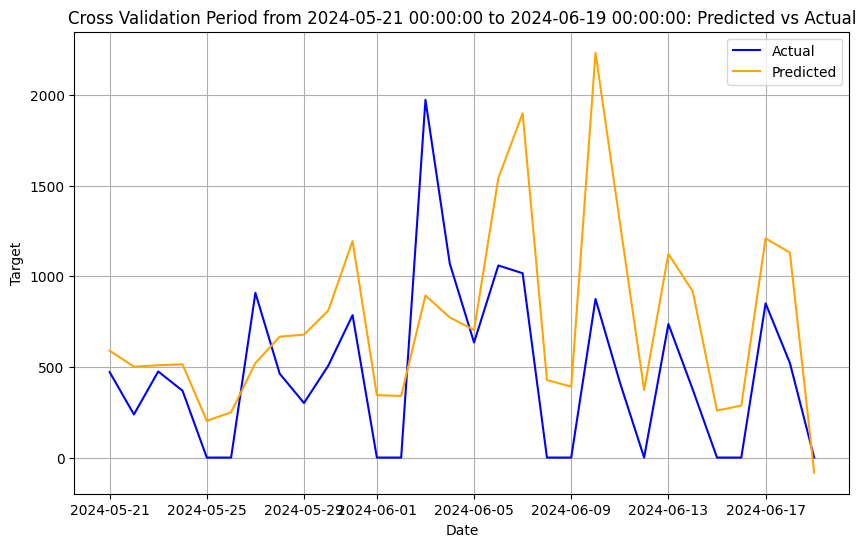

Среднее значение Train RMSE: 162.2986
Среднее значение Validation RMSE: 331.3800


In [14]:
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Датафрейм с данными
# df['target'] - это наш таргет, а остальная часть df - это фичи
X = day_data_df.drop(columns=[target])
y = day_data_df[target]

# Число дней в месяце
days_in_month = 30

# Число периодов кросс-валидации (12 месяцев)
n_splits = 12  

# Определяем TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=n_splits, test_size=days_in_month)

# Списки для сохранения метрик
train_errors = []
val_errors = []

# Процент данных для валидационного набора из тренировочного сета
validation_fraction = 0.2  # 20% от тренировочного набора будет использоваться для валидации

# Инициализируем StandardScaler для стандартизации фичей
scaler = StandardScaler()

# Кросс-валидация
for train_index, val_index in tscv.split(X):
    # Используем только последний месяц валидационного периода
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    
    # Запоминаем даты
    train_min_date = X_train['day_date'].min()
    train_max_date = X_train['day_date'].max()
    val_min_date = X_val['day_date'].min()
    val_max_date = X_val['day_date'].max()
    
    # Случайное разделение тренировочного набора на обучение и валидацию
    X_train_part, X_val_part, y_train_part, y_val_part = train_test_split(
        X_train, y_train, test_size=validation_fraction, shuffle=True, random_state=42
    )
    
    # Применяем стандартизацию к тренировочным данным
    X_train_part_scaled = scaler.fit_transform(X_train_part.drop(columns=exc_f))
    X_val_part_scaled = scaler.transform(X_val_part.drop(columns=exc_f))
    
    X_train_scaled = scaler.transform(X_train.drop(columns=exc_f))
    X_val_scaled = scaler.transform(X_val.drop(columns=exc_f))
    
    # Инициализация модели Lasso (L1-регуляризация)
    model = Lasso(alpha=0.1, random_state=42)  # Можно настроить параметр alpha
    
    # Обучаем модель
    model.fit(X_train_part.drop(columns=exc_f), y_train_part)
    
    # Предсказания на тренировочном и валидационном наборах
    y_train_pred = model.predict(X_train.drop(columns=exc_f))
    y_val_pred = model.predict(X_val.drop(columns=exc_f))
    
    # Оцениваем ошибки
    train_error = mean_squared_error(y_train, y_train_pred, squared=False)
    val_error = mean_squared_error(y_val, y_val_pred, squared=False)
    
    train_errors.append(train_error)
    val_errors.append(val_error)
    
    print(f'Train dates from {train_min_date} to {train_max_date}.\nVal dates from {val_min_date} to {val_max_date}.')
    print(f'Train RMSE: {train_error:.4f}, Validation RMSE (last month): {val_error:.4f} \n')
    
    # Нарисуем график
    plot_res(X_val, y_val, y_val_pred, val_min_date, val_max_date)


# Выводим средние ошибки по всем периодам кросс-валидации
print(f'Среднее значение Train RMSE: {np.mean(train_errors):.4f}')
print(f'Среднее значение Validation RMSE: {np.mean(val_errors):.4f}')

## Пробуем ради интереса LSTM
Ничего не получилось. Закоментил чтобы не тратить время запуска ноутбука

## Порешаем как классификацию

In [15]:
day_data_df['is_hight'] = np.where(day_data_df['target']>1000, 1, 0)

In [16]:
day_data_df['is_hight'].sum()/len(day_data_df)

0.019747235387045814

## Зафитим логрег
Но так делать нельзя из-за того, что мы подглядываем в будущее

Confusion Matrix:
[[349  20]
 [  2   9]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.95      0.97       369
           1       0.31      0.82      0.45        11

    accuracy                           0.94       380
   macro avg       0.65      0.88      0.71       380
weighted avg       0.97      0.94      0.95       380


ROC AUC: 0.9731


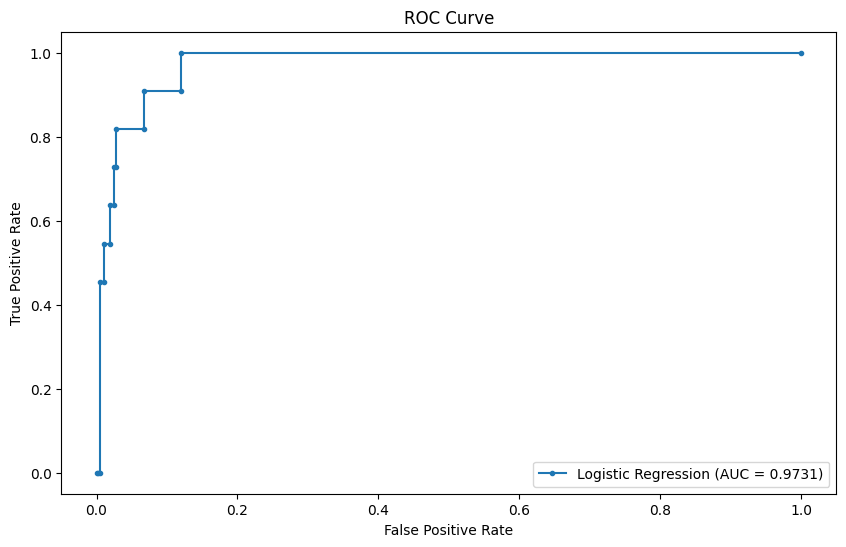

Model Coefficients:
[[-1.19308452 -0.7449622  -0.74095623  0.33195622  0.68058044 -1.02800766
   2.55305788  0.49559837  0.05227843  0.73427511 -2.17639507 -2.24549493
   0.29988132 -0.74914543 -0.0867587   0.70739327]]


In [17]:
# Создаем фичи и целевую переменную
X = day_data_df.drop(columns=['target', 'is_hight'])
y = day_data_df['is_hight']

# Разделяем данные на тренировочный и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Нормируем или стандартизируем фичи
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.drop(columns=exc_f))
X_test_scaled = scaler.transform(X_test.drop(columns=exc_f))

# Создаем и обучаем модель логистической регрессии
model = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
model.fit(X_train_scaled, y_train)

# Предсказания на тестовом наборе
y_pred = model.predict(X_test_scaled)
y_proba = model.predict_proba(X_test_scaled)[:, 1]  # Вероятности для положительного класса


# Оцениваем модель
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# ROC AUC
roc_auc = roc_auc_score(y_test, y_proba)
print(f'\nROC AUC: {roc_auc:.4f}')

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, marker='.', label='Logistic Regression (AUC = %0.4f)' % roc_auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Коэффициенты модели
print("Model Coefficients:")
print(model.coef_)

## Фитим логрег, но уже без подглядываний
Так то лучше

Confusion Matrix:
[[331  12]
 [ 11   6]]

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       343
           1       0.33      0.35      0.34        17

    accuracy                           0.94       360
   macro avg       0.65      0.66      0.65       360
weighted avg       0.94      0.94      0.94       360


ROC AUC: 0.6891


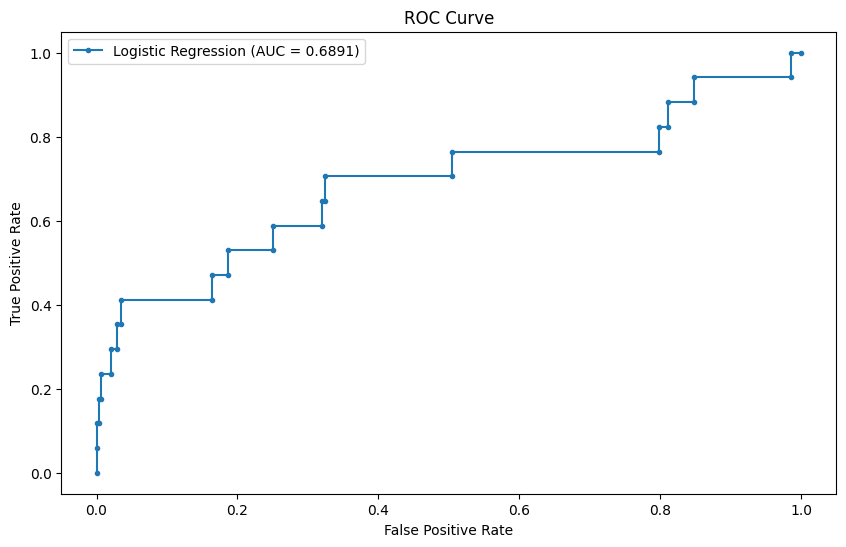

Model Coefficients:
[[-0.60771823 -0.46070188 -0.54622136  0.57091813  0.29221868 -0.90089319
   3.20946588  0.20238738 -0.14209565  0.16790924 -2.65735978 -2.20600949
   0.47167192 -0.38579012 -1.06634448  1.10800365]]


In [18]:
# Создаем фичи и целевую переменную
X = day_data_df.drop(columns=['target', 'is_hight'])
y = day_data_df['is_hight']

# Параметры для TimeSeriesSplit
days_in_month = 30
n_splits = 12
tscv = TimeSeriesSplit(n_splits=n_splits, test_size=days_in_month)

# Списки для сохранения метрик
y_true_all = []
y_pred_all = []
y_proba_all = []

for train_index, val_index in tscv.split(X):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    
    # Запоминаем даты
    train_min_date = X_train['day_date'].min()
    train_max_date = X_train['day_date'].max()
    val_min_date = X_val['day_date'].min()
    val_max_date = X_val['day_date'].max()
    
    # Нормируем или стандартизируем фичи
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train.drop(columns=exc_f))
    X_val_scaled = scaler.transform(X_val.drop(columns=exc_f))

    # Создаем и обучаем модель логистической регрессии
    model = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
    model.fit(X_train_scaled, y_train)

    # Предсказания на валидационном наборе
    y_val_pred = model.predict(X_val_scaled)
    y_val_proba = model.predict_proba(X_val_scaled)[:, 1]  # Вероятности для положительного класса
    
    # Аккумулируем результаты
    y_true_all.extend(y_val)
    y_pred_all.extend(y_val_pred)
    y_proba_all.extend(y_val_proba)

# Оцениваем модель на всех данных
print("Confusion Matrix:")
print(confusion_matrix(y_true_all, y_pred_all))
print("\nClassification Report:")
print(classification_report(y_true_all, y_pred_all))

# ROC AUC
roc_auc = roc_auc_score(y_true_all, y_proba_all)
print(f'\nROC AUC: {roc_auc:.4f}')

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_true_all, y_proba_all)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, marker='.', label='Logistic Regression (AUC = %0.4f)' % roc_auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Коэффициенты модели (выводятся для последней модели, так как валидация была выполнена только один раз)
print("Model Coefficients:")
print(model.coef_)


## Фитим RF как классификатор
Результат намного лучше

Confusion Matrix:
[[343   0]
 [ 17   0]]

Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.98       343
           1       0.00      0.00      0.00        17

    accuracy                           0.95       360
   macro avg       0.48      0.50      0.49       360
weighted avg       0.91      0.95      0.93       360


ROC AUC: 0.8773


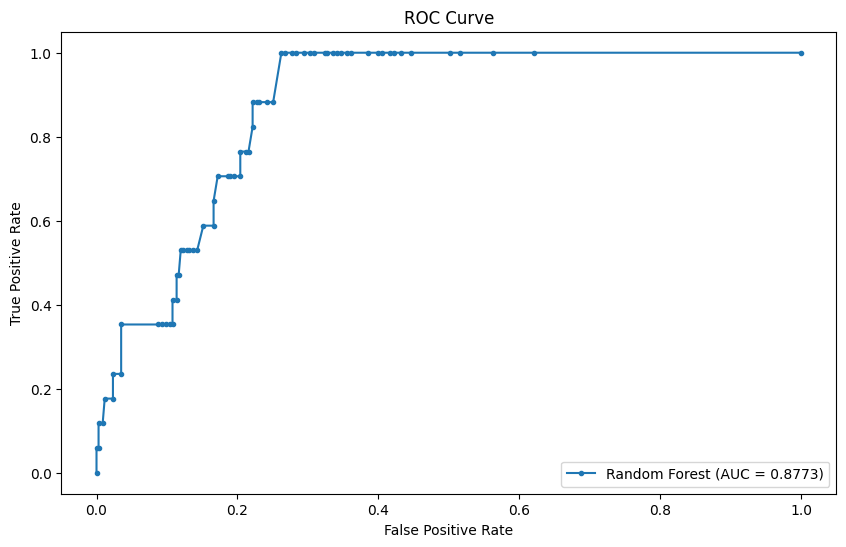

Feature Importances:
[0.03321707 0.04058464 0.03038556 0.01181445 0.01404939 0.00648126
 0.32345761 0.06345122 0.00074414 0.00056612 0.06962083 0.03972398
 0.12007288 0.01265103 0.09602957 0.13715025]


In [19]:
# Создаем фичи и целевую переменную
X = day_data_df.drop(columns=['target', 'is_hight'])
y = day_data_df['is_hight']

# Параметры для TimeSeriesSplit
days_in_month = 30
n_splits = 12
tscv = TimeSeriesSplit(n_splits=n_splits, test_size=days_in_month)

# Списки для сохранения метрик
y_true_all = []
y_pred_all = []
y_proba_all = []

for train_index, val_index in tscv.split(X):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    
    # Запоминаем даты
    train_min_date = X_train['day_date'].min()
    train_max_date = X_train['day_date'].max()
    val_min_date = X_val['day_date'].min()
    val_max_date = X_val['day_date'].max()
    
    # Нормируем или стандартизируем фичи
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train.drop(columns=exc_f))
    X_val_scaled = scaler.transform(X_val.drop(columns=exc_f))

    # Создаем и обучаем модель RandomForestClassifier
    model = RandomForestClassifier(n_estimators=1000, random_state=42, class_weight='balanced')
    model.fit(X_train_scaled, y_train)

    # Предсказания на валидационном наборе
    y_val_pred = model.predict(X_val_scaled)
    y_val_proba = model.predict_proba(X_val_scaled)[:, 1]  # Вероятности для положительного класса
    
    # Аккумулируем результаты
    y_true_all.extend(y_val)
    y_pred_all.extend(y_val_pred)
    y_proba_all.extend(y_val_proba)

# Оцениваем модель на всех данных
print("Confusion Matrix:")
print(confusion_matrix(y_true_all, y_pred_all))
print("\nClassification Report:")
print(classification_report(y_true_all, y_pred_all))

# ROC AUC
roc_auc = roc_auc_score(y_true_all, y_proba_all)
print(f'\nROC AUC: {roc_auc:.4f}')

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_true_all, y_proba_all)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, marker='.', label='Random Forest (AUC = %0.4f)' % roc_auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Особенности модели (выводятся для последней модели, так как валидация была выполнена только один раз)
print("Feature Importances:")
print(model.feature_importances_)

## Зафитим RF как регрессор, но потом переведем результаты в бинарную классификацию
С ходу результат по ROC AUC получается лучше, чем если решать как классификацию. Но однозначных выводов делать нельзя, так как мы не пытались нормально тюнить и то и другое

Train dates from 2021-01-01 00:00:00 to 2023-06-25 00:00:00.
Val dates from 2023-06-26 00:00:00 to 2023-07-25 00:00:00.
Train RMSE: 55.0771, Validation RMSE (last month): 11.9613 

Train dates from 2021-01-01 00:00:00 to 2023-07-25 00:00:00.
Val dates from 2023-07-26 00:00:00 to 2023-08-24 00:00:00.
Train RMSE: 54.4041, Validation RMSE (last month): 585.4120 

Train dates from 2021-01-01 00:00:00 to 2023-08-24 00:00:00.
Val dates from 2023-08-25 00:00:00 to 2023-09-23 00:00:00.
Train RMSE: 57.5577, Validation RMSE (last month): 292.9367 

Train dates from 2021-01-01 00:00:00 to 2023-09-23 00:00:00.
Val dates from 2023-09-24 00:00:00 to 2023-10-23 00:00:00.
Train RMSE: 55.0454, Validation RMSE (last month): 301.3009 

Train dates from 2021-01-01 00:00:00 to 2023-10-23 00:00:00.
Val dates from 2023-10-24 00:00:00 to 2023-11-22 00:00:00.
Train RMSE: 53.9067, Validation RMSE (last month): 419.1484 

Train dates from 2021-01-01 00:00:00 to 2023-11-22 00:00:00.
Val dates from 2023-11-23 00:0

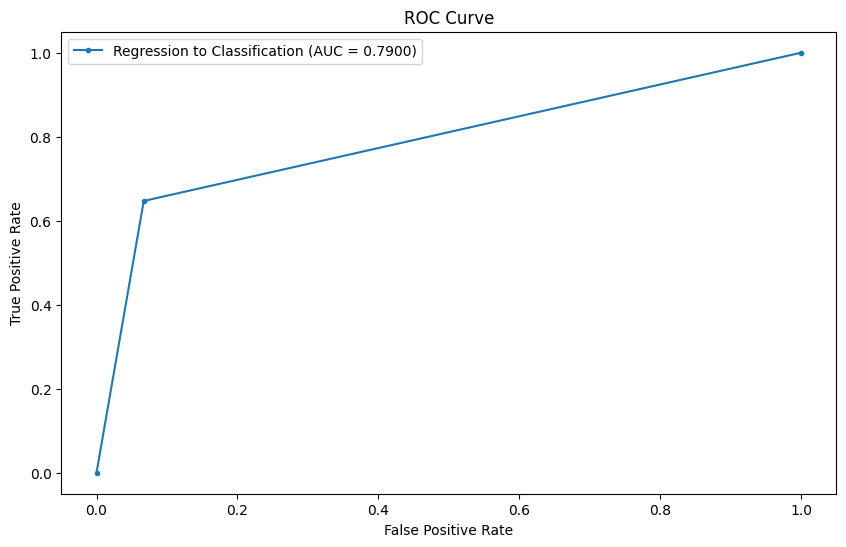

Среднее значение Train RMSE: 53.9142
Среднее значение Validation RMSE: 296.9068


In [20]:
# Создаем фичи и целевую переменную
X = day_data_df.drop(columns=['target', 'is_hight'])
y = day_data_df['target']

# Параметры для TimeSeriesSplit
days_in_month = 30
n_splits = 12
tscv = TimeSeriesSplit(n_splits=n_splits, test_size=days_in_month)

# Создаем и обучаем модель RandomForestRegressor
regressor = RandomForestRegressor(random_state=42, n_estimators=1000)

# Списки для сохранения метрик
y_true_all = []
y_pred_all = []
y_proba_all = []
train_errors = []
val_errors = []

for train_index, val_index in tscv.split(X):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    
    # Запоминаем даты
    train_min_date = X_train['day_date'].min()
    train_max_date = X_train['day_date'].max()
    val_min_date = X_val['day_date'].min()
    val_max_date = X_val['day_date'].max()
    
    # Обучаем модель на тренировочных данных
    regressor.fit(X_train.drop(columns=exc_f), y_train)
    
    # Предсказания на тренировочном и валидационном наборах
    y_train_pred = regressor.predict(X_train.drop(columns=exc_f))
    y_val_pred = regressor.predict(X_val.drop(columns=exc_f))
    
    # Переводим прогнозы в бинарные предсказания по порогу 1000
    y_train_pred_binary = np.where(y_train_pred > 1000, 1, 0)
    y_val_pred_binary = np.where(y_val_pred > 1000, 1, 0)
    y_val_binary = np.where(y_val > 1000, 1, 0)
    
    
    # Оцениваем ошибки
    train_error = mean_squared_error(y_train, y_train_pred, squared=False)
    val_error = mean_squared_error(y_val, y_val_pred, squared=False)
    
    train_errors.append(train_error)
    val_errors.append(val_error)
    
    # Аккумулируем результаты
    y_true_all.extend(y_val_binary)
    y_pred_all.extend(y_val_pred_binary)
    y_proba_all.extend(y_val_pred)
    
    print(f'Train dates from {train_min_date} to {train_max_date}.')
    print(f'Val dates from {val_min_date} to {val_max_date}.')
    print(f'Train RMSE: {train_error:.4f}, Validation RMSE (last month): {val_error:.4f} \n')
    
#     # Нарисуем график
#     plot_res(X_val, y_val, y_val_pred, val_min_date, val_max_date)

# Оцениваем классификацию на всех данных
print("Confusion Matrix:")
print(confusion_matrix(y_true_all, y_pred_all))
print("\nClassification Report:")
print(classification_report(y_true_all, y_pred_all))

# ROC AUC
roc_auc = roc_auc_score(y_true_all, y_pred_all)
print(f'\nROC AUC: {roc_auc:.4f}')

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_true_all, y_pred_all)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, marker='.', label='Regression to Classification (AUC = %0.4f)' % roc_auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Выводим средние ошибки по всем периодам кросс-валидации
print(f'Среднее значение Train RMSE: {np.mean(train_errors):.4f}')
print(f'Среднее значение Validation RMSE: {np.mean(val_errors):.4f}')

## Поизучаем корреляцию таргета с лагами фичей

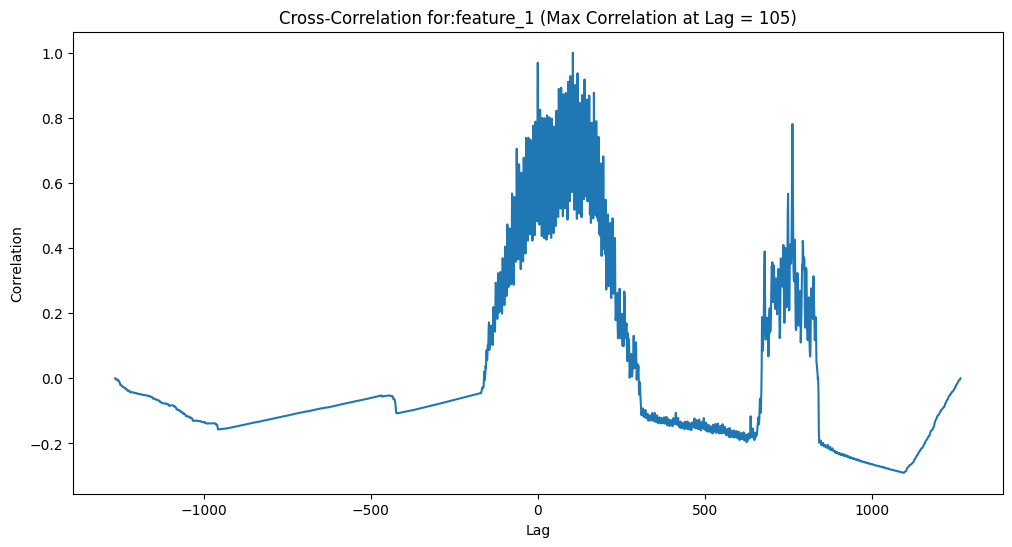

Наибольшая корреляция обнаруживается при задержке 105.


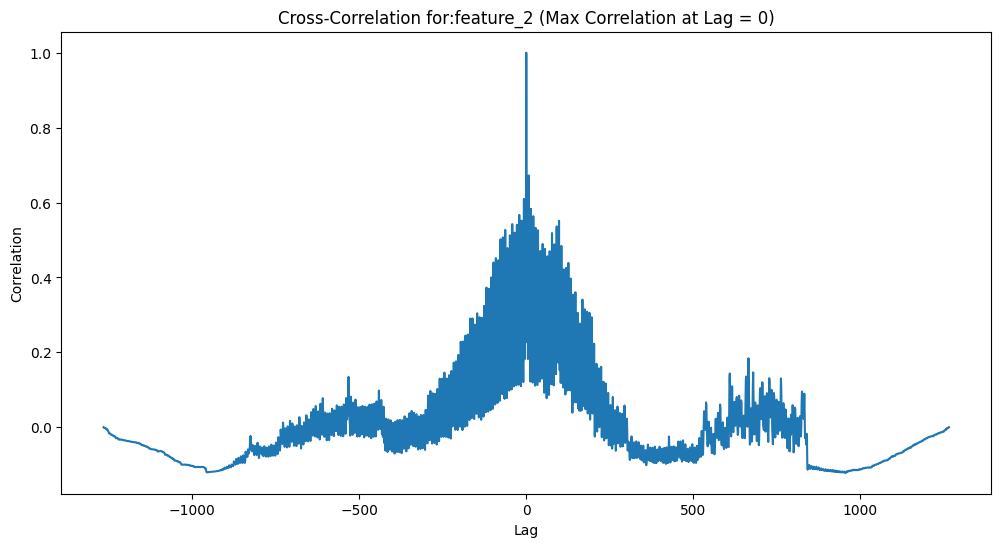

Наибольшая корреляция обнаруживается при задержке 0.


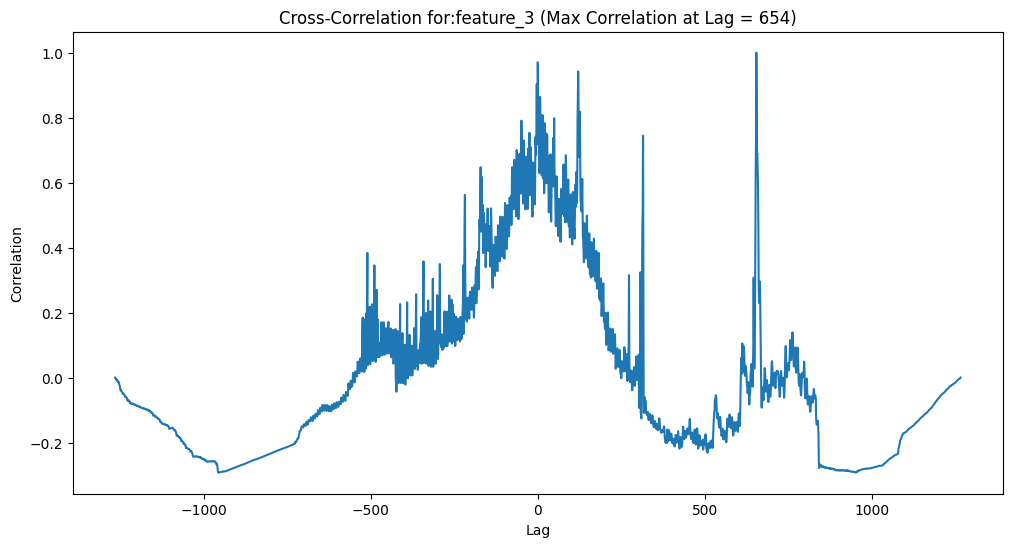

Наибольшая корреляция обнаруживается при задержке 654.


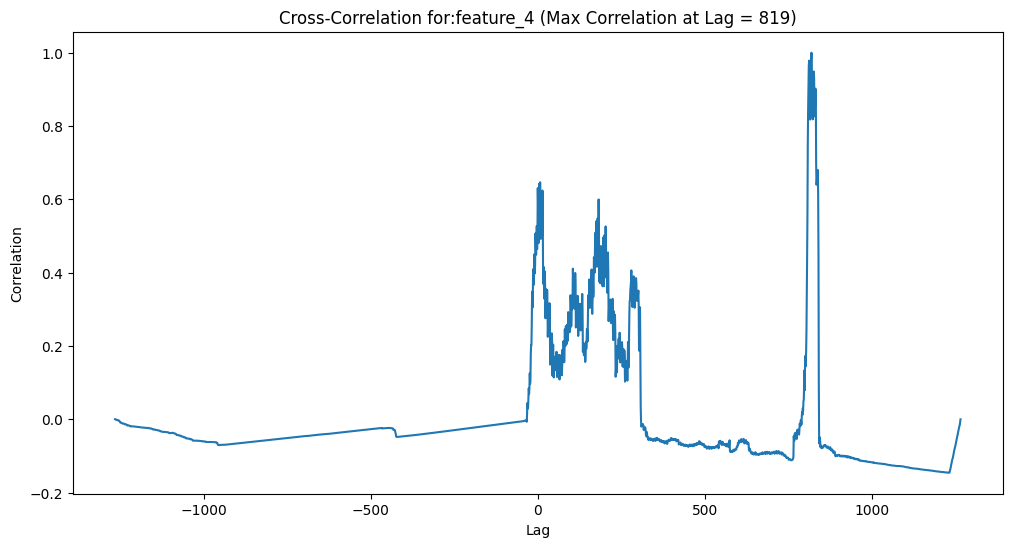

Наибольшая корреляция обнаруживается при задержке 819.


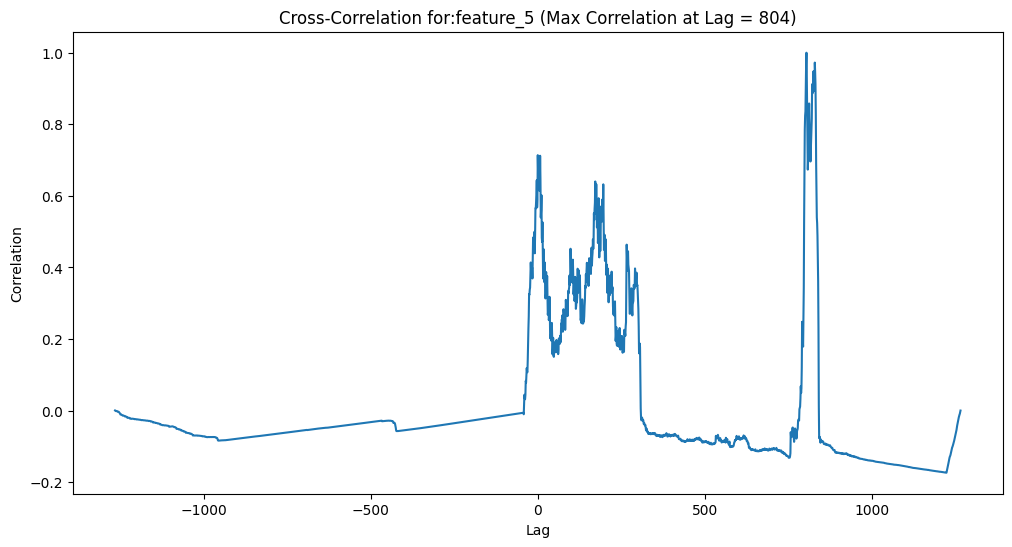

Наибольшая корреляция обнаруживается при задержке 804.


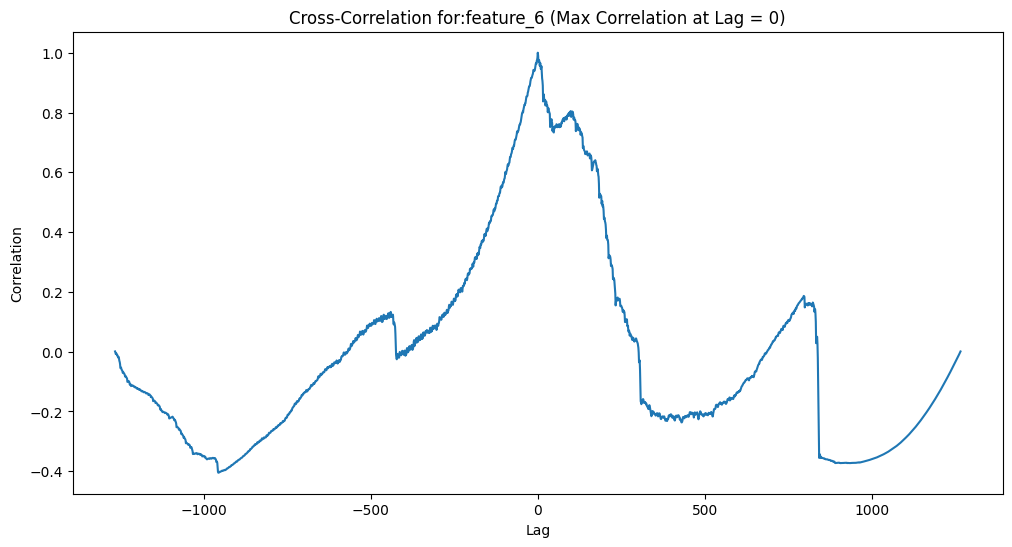

Наибольшая корреляция обнаруживается при задержке 0.


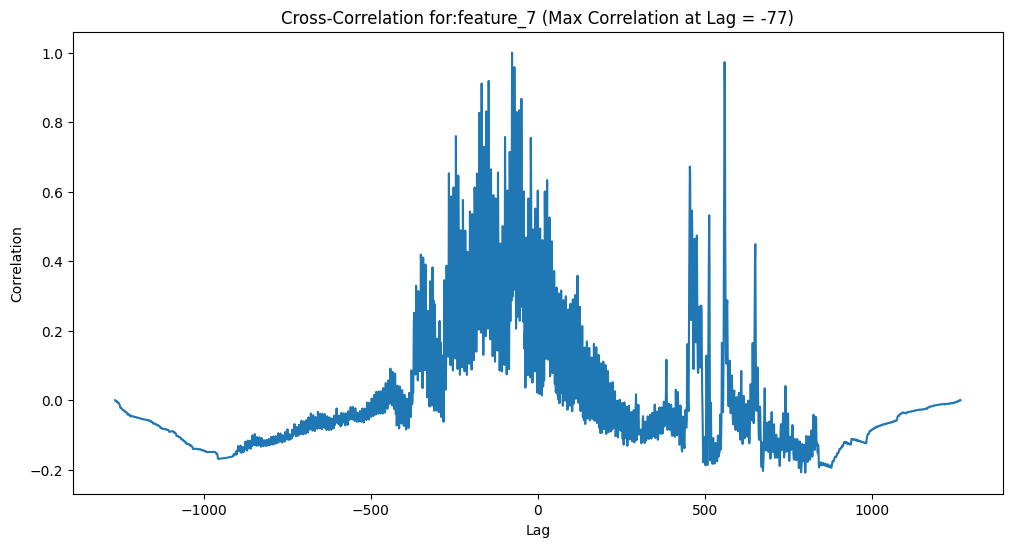

Наибольшая корреляция обнаруживается при задержке -77.


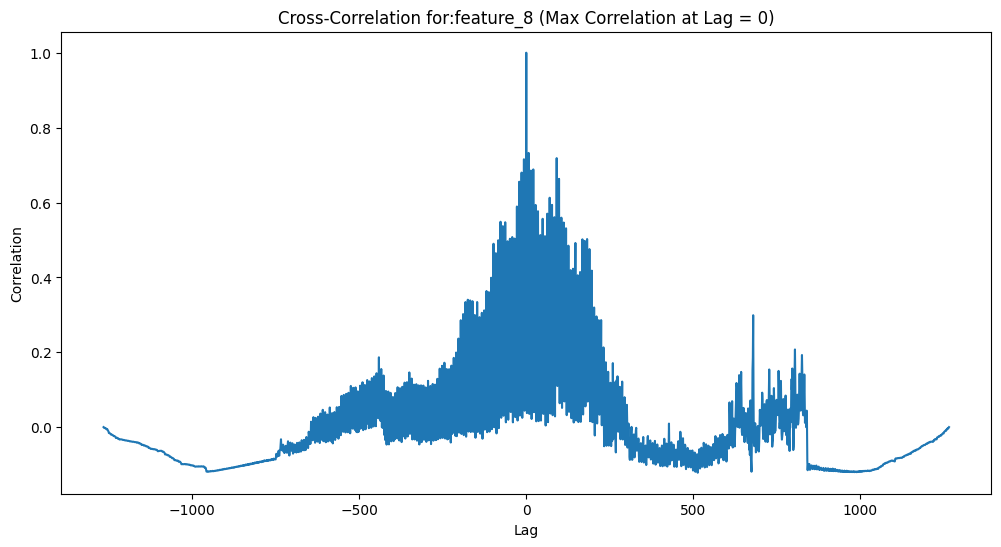

Наибольшая корреляция обнаруживается при задержке 0.


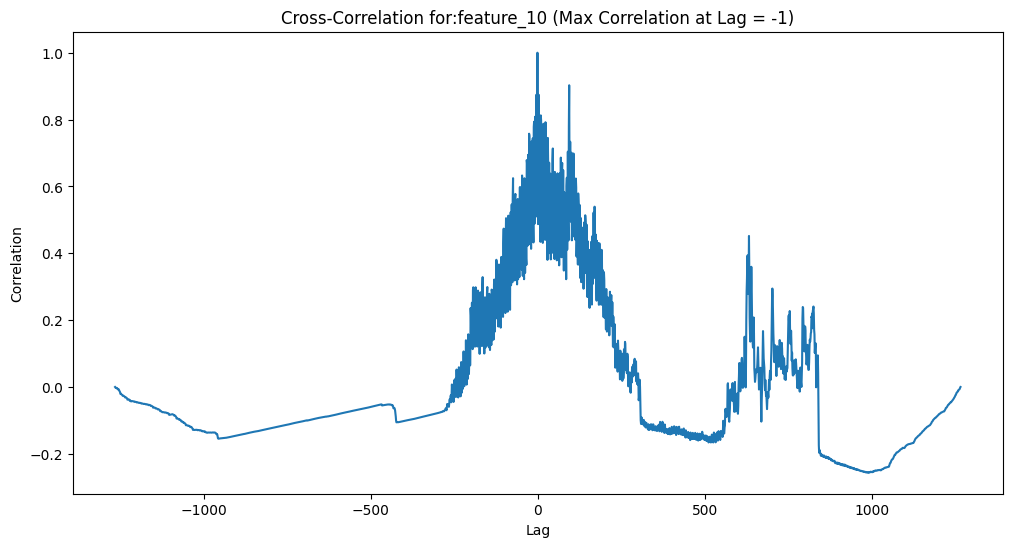

Наибольшая корреляция обнаруживается при задержке -1.


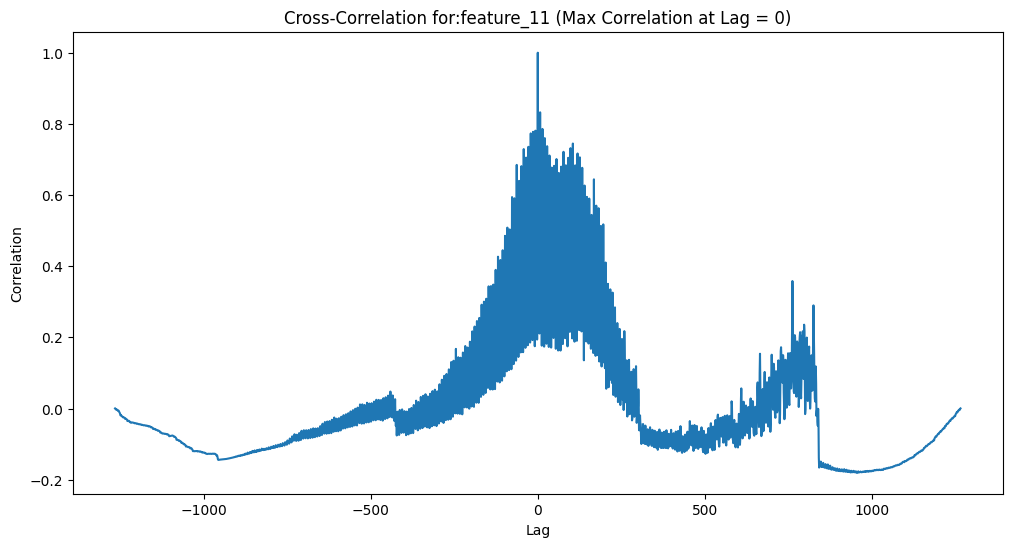

Наибольшая корреляция обнаруживается при задержке 0.


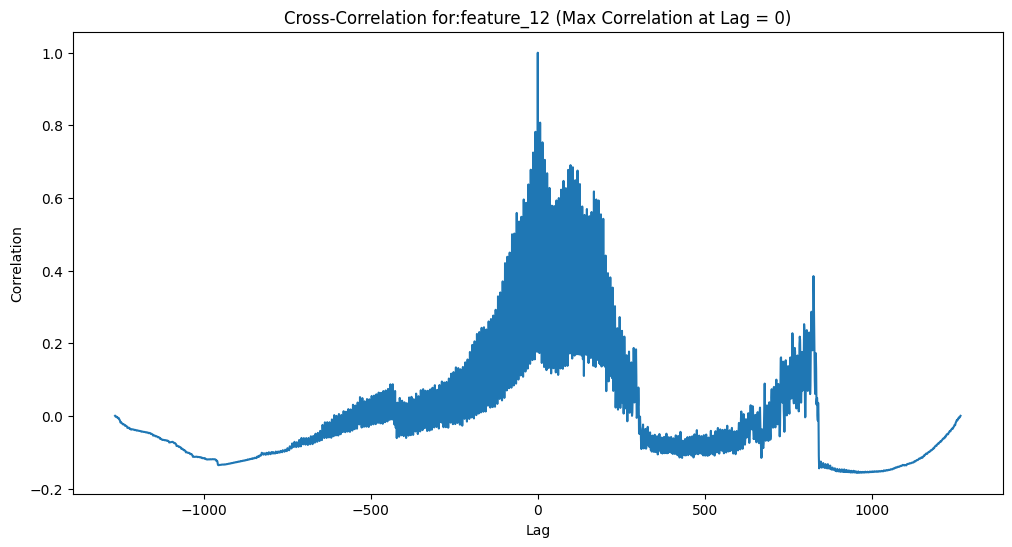

Наибольшая корреляция обнаруживается при задержке 0.


In [21]:
for feature_name in features:
    # Преобразуем данные в массивы numpy
    feature = day_data_df[feature_name].values
    target = day_data_df['target'].values

    # Нормализуем данные для корреляции
    feature -= np.mean(feature)
    target -= np.mean(target)

    # Вычисляем кросс-корреляцию
    correlation = correlate(feature, target, mode='full')
    lags = np.arange(-len(feature) + 1, len(target))

    # Нормируем кросс-корреляцию
    correlation /= np.max(correlation)

    # Нахождение максимальной корреляции
    lag = lags[np.argmax(correlation)]

    # Визуализируем кросс-корреляцию
    plt.figure(figsize=(12, 6))
    plt.plot(lags, correlation)
    plt.title(f'Cross-Correlation for:{feature_name} (Max Correlation at Lag = {lag})')
    plt.xlabel('Lag')
    plt.ylabel('Correlation')
    plt.show()

    print(f'Наибольшая корреляция обнаруживается при задержке {lag}.')


## Сгенерим пару лаговых фич и посмотрим на результат
Разницы нет

In [22]:
# Генерация лаговых фичей
day_data_df['feature_10_lag_1'] = day_data_df['feature_10'].shift(-1)
day_data_df['feature_7_lag_77'] = day_data_df['feature_7'].shift(-77)

day_data_df[['feature_10_lag_1', 'feature_7_lag_77']] = day_data_df[['feature_10_lag_1', 'feature_7_lag_77']].fillna(0)

Train dates from 2021-01-01 00:00:00 to 2023-06-25 00:00:00.
Val dates from 2023-06-26 00:00:00 to 2023-07-25 00:00:00.
Train RMSE: 54.7026, Validation RMSE (last month): 10.9311 

Train dates from 2021-01-01 00:00:00 to 2023-07-25 00:00:00.
Val dates from 2023-07-26 00:00:00 to 2023-08-24 00:00:00.
Train RMSE: 54.3531, Validation RMSE (last month): 595.8228 

Train dates from 2021-01-01 00:00:00 to 2023-08-24 00:00:00.
Val dates from 2023-08-25 00:00:00 to 2023-09-23 00:00:00.
Train RMSE: 59.5576, Validation RMSE (last month): 301.4249 

Train dates from 2021-01-01 00:00:00 to 2023-09-23 00:00:00.
Val dates from 2023-09-24 00:00:00 to 2023-10-23 00:00:00.
Train RMSE: 56.1591, Validation RMSE (last month): 313.1967 

Train dates from 2021-01-01 00:00:00 to 2023-10-23 00:00:00.
Val dates from 2023-10-24 00:00:00 to 2023-11-22 00:00:00.
Train RMSE: 54.0051, Validation RMSE (last month): 430.8120 

Train dates from 2021-01-01 00:00:00 to 2023-11-22 00:00:00.
Val dates from 2023-11-23 00:0

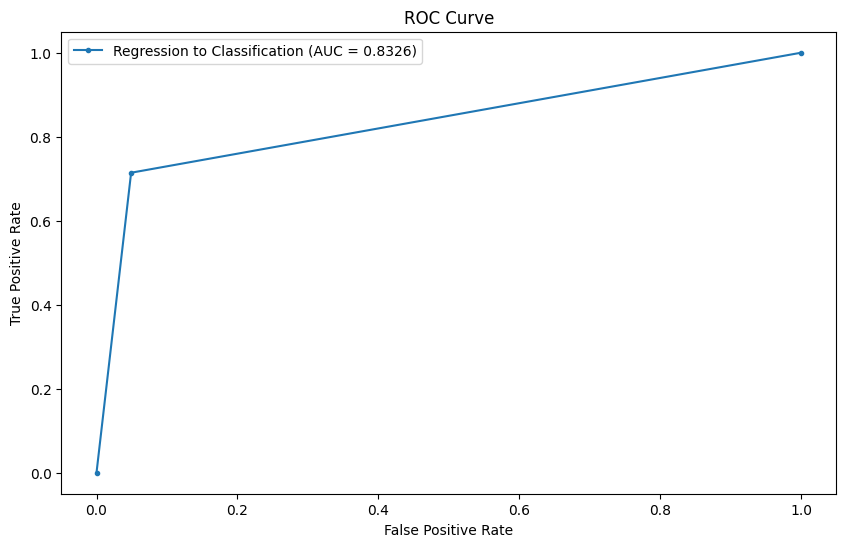

Среднее значение Train RMSE: 53.8996
Среднее значение Validation RMSE: 301.4243


In [23]:
# Создаем фичи и целевую переменную
X = day_data_df.drop(columns=['target', 'is_hight'])
y = day_data_df['target']

# Параметры для TimeSeriesSplit
days_in_month = 30
n_splits = 12
tscv = TimeSeriesSplit(n_splits=n_splits, test_size=days_in_month)

# Создаем и обучаем модель RandomForestRegressor
regressor = RandomForestRegressor(random_state=42, n_estimators=1000)

# Списки для сохранения метрик
y_true_all = []
y_pred_all = []
y_proba_all = []
train_errors = []
val_errors = []

for train_index, val_index in tscv.split(X):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    
    # Запоминаем даты
    train_min_date = X_train['day_date'].min()
    train_max_date = X_train['day_date'].max()
    val_min_date = X_val['day_date'].min()
    val_max_date = X_val['day_date'].max()
    
    # Обучаем модель на тренировочных данных
    regressor.fit(X_train.drop(columns=exc_f), y_train)
    
    # Предсказания на тренировочном и валидационном наборах
    y_train_pred = regressor.predict(X_train.drop(columns=exc_f))
    y_val_pred = regressor.predict(X_val.drop(columns=exc_f))
    
    # Переводим прогнозы в бинарные предсказания по порогу 1000
    y_train_pred_binary = np.where(y_train_pred > 1000, 1, 0)
    y_val_pred_binary = np.where(y_val_pred > 1000, 1, 0)
    y_val_binary = np.where(y_val > 1000, 1, 0)
    
    
    # Оцениваем ошибки
    train_error = mean_squared_error(y_train, y_train_pred, squared=False)
    val_error = mean_squared_error(y_val, y_val_pred, squared=False)
    
    train_errors.append(train_error)
    val_errors.append(val_error)
    
    # Аккумулируем результаты
    y_true_all.extend(y_val_binary)
    y_pred_all.extend(y_val_pred_binary)
    y_proba_all.extend(y_val_pred)
    
    print(f'Train dates from {train_min_date} to {train_max_date}.')
    print(f'Val dates from {val_min_date} to {val_max_date}.')
    print(f'Train RMSE: {train_error:.4f}, Validation RMSE (last month): {val_error:.4f} \n')
    
#     # Нарисуем график
#     plot_res(X_val, y_val, y_val_pred, val_min_date, val_max_date)

# Оцениваем классификацию на всех данных
print("Confusion Matrix:")
print(confusion_matrix(y_true_all, y_pred_all))
print("\nClassification Report:")
print(classification_report(y_true_all, y_pred_all))

# ROC AUC
roc_auc = roc_auc_score(y_true_all, y_pred_all)
print(f'\nROC AUC: {roc_auc:.4f}')

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_true_all, y_pred_all)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, marker='.', label='Regression to Classification (AUC = %0.4f)' % roc_auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Выводим средние ошибки по всем периодам кросс-валидации
print(f'Среднее значение Train RMSE: {np.mean(train_errors):.4f}')
print(f'Среднее значение Validation RMSE: {np.mean(val_errors):.4f}')

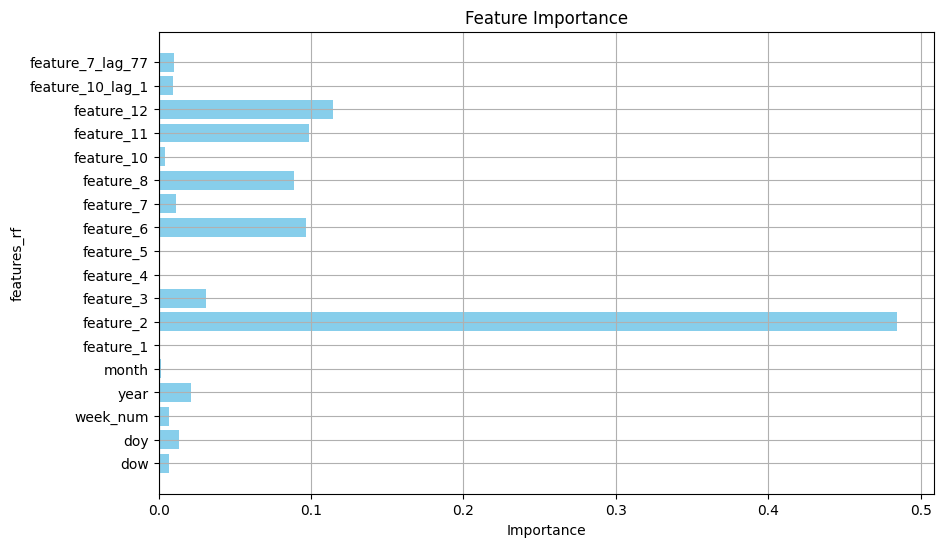

In [24]:
# Вывод важности признаков для последней модели
feature_importance = regressor.feature_importances_
features_rf = X_train.drop(columns=exc_f).columns

# Построение графика важности признаков
plt.figure(figsize=(10, 6))
plt.barh(features_rf, feature_importance, color='skyblue')
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('features_rf')
plt.grid(True)
plt.show()

## Пробуем с наскока решить через quantile loss
Получается не очень, мало объектов детектится

Train dates from 2021-01-01 00:00:00 to 2023-06-25 00:00:00.
Val dates from 2023-06-26 00:00:00 to 2023-07-25 00:00:00.
Train RMSE: 78.9000, Validation RMSE (last month): 31.7425 

Train dates from 2021-01-01 00:00:00 to 2023-07-25 00:00:00.
Val dates from 2023-07-26 00:00:00 to 2023-08-24 00:00:00.
Train RMSE: 85.0359, Validation RMSE (last month): 548.9342 

Train dates from 2021-01-01 00:00:00 to 2023-08-24 00:00:00.
Val dates from 2023-08-25 00:00:00 to 2023-09-23 00:00:00.
Train RMSE: 100.9834, Validation RMSE (last month): 275.7919 

Train dates from 2021-01-01 00:00:00 to 2023-09-23 00:00:00.
Val dates from 2023-09-24 00:00:00 to 2023-10-23 00:00:00.
Train RMSE: 105.6577, Validation RMSE (last month): 184.1932 

Train dates from 2021-01-01 00:00:00 to 2023-10-23 00:00:00.
Val dates from 2023-10-24 00:00:00 to 2023-11-22 00:00:00.
Train RMSE: 110.8623, Validation RMSE (last month): 319.7433 

Train dates from 2021-01-01 00:00:00 to 2023-11-22 00:00:00.
Val dates from 2023-11-23 0

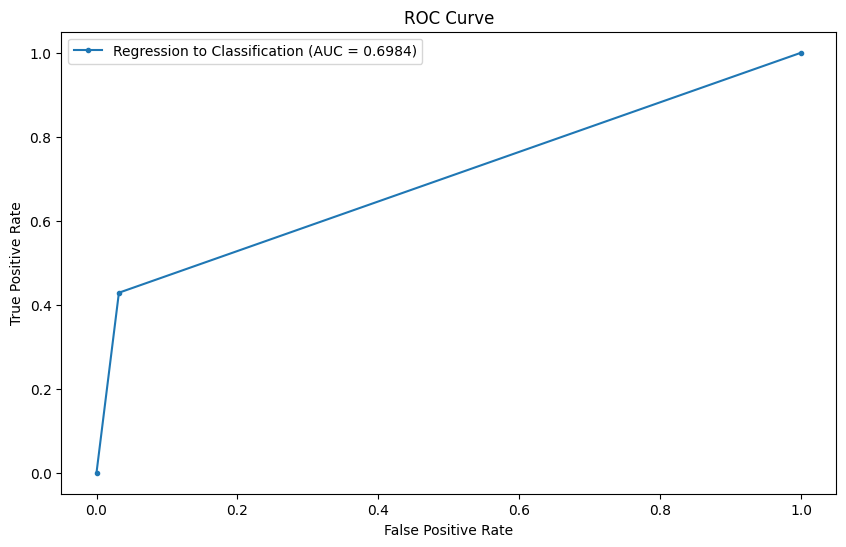

Среднее значение Train RMSE: 149.4253
Среднее значение Validation RMSE: 299.1292


In [25]:
# Создаем фичи и целевую переменную
X = day_data_df.drop(columns=['target', 'is_hight'])
y = day_data_df['target']

# Параметры для TimeSeriesSplit
days_in_month = 30
n_splits = 12
tscv = TimeSeriesSplit(n_splits=n_splits, test_size=days_in_month)

# Создаем и обучаем модель CatBoostRegressor
regressor = CatBoostRegressor(
    loss_function='Quantile:alpha=0.98',
    random_state=42, 
    n_estimators=100,
    verbose=0,
)

# Списки для сохранения метрик
y_true_all = []
y_pred_all = []
y_proba_all = []
train_errors = []
val_errors = []

for train_index, val_index in tscv.split(X):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    
    # Запоминаем даты
    train_min_date = X_train['day_date'].min()
    train_max_date = X_train['day_date'].max()
    val_min_date = X_val['day_date'].min()
    val_max_date = X_val['day_date'].max()
    
    # Обучаем модель на тренировочных данных
    regressor.fit(X_train.drop(columns=exc_f), y_train)
    
    # Предсказания на тренировочном и валидационном наборах
    y_train_pred = regressor.predict(X_train.drop(columns=exc_f))
    y_val_pred = regressor.predict(X_val.drop(columns=exc_f))
    
    # Переводим прогнозы в бинарные предсказания по порогу 1000
    y_train_pred_binary = np.where(y_train_pred > 1000, 1, 0)
    y_val_pred_binary = np.where(y_val_pred > 1000, 1, 0)
    y_val_binary = np.where(y_val > 1000, 1, 0)
    
    
    # Оцениваем ошибки
    train_error = mean_squared_error(y_train, y_train_pred, squared=False)
    val_error = mean_squared_error(y_val, y_val_pred, squared=False)
    
    train_errors.append(train_error)
    val_errors.append(val_error)
    
    # Аккумулируем результаты
    y_true_all.extend(y_val_binary)
    y_pred_all.extend(y_val_pred_binary)
    y_proba_all.extend(y_val_pred)
    
    print(f'Train dates from {train_min_date} to {train_max_date}.')
    print(f'Val dates from {val_min_date} to {val_max_date}.')
    print(f'Train RMSE: {train_error:.4f}, Validation RMSE (last month): {val_error:.4f} \n')
    
#     # Нарисуем график
#     plot_res(X_val, y_val, y_val_pred, val_min_date, val_max_date)

# Оцениваем классификацию на всех данных
print("Confusion Matrix:")
print(confusion_matrix(y_true_all, y_pred_all))
print("\nClassification Report:")
print(classification_report(y_true_all, y_pred_all))

# ROC AUC
roc_auc = roc_auc_score(y_true_all, y_pred_all)
print(f'\nROC AUC: {roc_auc:.4f}')

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_true_all, y_pred_all)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, marker='.', label='Regression to Classification (AUC = %0.4f)' % roc_auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Выводим средние ошибки по всем периодам кросс-валидации
print(f'Среднее значение Train RMSE: {np.mean(train_errors):.4f}')
print(f'Среднее значение Validation RMSE: {np.mean(val_errors):.4f}')

## Выводы
На текущем этапе кажется что через RF классификатор получается лучше всего по ROC AUC и удобно что можно самому регулировать порог и делать trade-off между полотой и ложными срабатываниями.  
Можно много чего пробовать. Очень многое зависит от бизнес-требований, без детальной проработки всё что было сделано - игрушки.  
По ощущениям, отработано только 5-10% всех гипотез и подходов. Не было попыток игнорирования фичей (ранее гововил что может мы их вообще не знаем на будущее), не прогнозили на уровне часов, не делали extencive feature engineering и многое-многое другое.  
